# Series Temporales
**Autor:** José A. Troyano &nbsp;&nbsp;&nbsp;  **Revisor:** Beatriz Pontes, Fernando Enríquez &nbsp;&nbsp;&nbsp;  **Última modificación:** 10/01/2024
    
---------------------------------------------------------------------
## Contenido
1. <a href="#lectura"> Lectura de datos</a> <br>
2. <a href="#visualizacion"> Visualización, tendencia, estacionalidad y estacionariedad</a> <br>
3. <a href="#preprocesado"> Preprocesado</a> <br>
4. <a href="#evaluacion"> Evaluación de predicciones </a> <br>
5. <a href="#ventanas"> Creación de ventanas de datos </a> <br>
6. <a href="#un_paso"> Predicción simple </a> <br>
7. <a href="#varios_pasos"> Predicción múltiple </a> <br>


---------------------------------------------------------------------

En este notebook veremos cómo trabajar con datos indexados por tiempo, lo que se conoce como series temporales. En concreto nos centraremos en la tarea de predicción (_time series forecasting_) multivariable, es decir, intentar anticipar el resultado de una serie tomando los valores anteriores de dicha serie y los de otras series de datos que pueden aportar información adicional. Para resolver esta tarea utilizaremos redes neuronales, pero hay muchas otras aproximaciones y técnicas relacionadas con las series temporales. He aquí algunos recursos que pueden servir para empezar a tirar del hilo de este interesante campo:

- <a href="https://towardsdatascience.com/an-overview-of-time-series-forecasting-models-a2fa7a358fcb"> Introducción a las series temporales</a> 
- <a href="https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788">Modelos autorregresivos y de suavizado exponencial</a> 
- <a href="https://towardsdatascience.com/a-quick-deep-learning-recipe-time-series-forecasting-with-keras-in-python-f759923ba64"> Series temporales y redes neuronales</a>

Empezaremos por importar todos los módulos que usaremos a lo largo del notebook:

In [2]:
# Librería estándar
import os
import datetime

# Análisis numérico y datasets
import numpy as np
from scipy import stats

# Análisis y preprocesado de series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Módulos locales, extraidos de la documentación de TensorFlow
from window_generator import WindowGenerator

# Librerías de machine learning
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf  #pip install --upgrade pip   #pip install tensorflow

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

2024-01-26 11:59:47.707196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Lectura de datos <a name="lectura"> </a>

Usaremos distintos datasets en los ejercicios de este notebook, algunos de ellos trendrán cierto componente estacional y otros no:

- **<a href='https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data'>weather-delhi</a>**: datos climátidos de la ciudad de Delhi. 
- **<a href='https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD'>bicoin-usd</a>**: cotización de bitcoin en dólares. 
- **<a href='https://www.kaggle.com/datasets/aramacus/electricity-demand-in-victoria-australia'>electricity-price</a>**: precio de la electricidad en Melbourne. 
- **<a href='https://www.kaggle.com/datasets/psycon/daily-coffee-price'>coffee-price</a>**: precio internacional del café. 

Se han resaltado en negrita los nombres de los ficheros de datos. Se encuentran en la carpeta <code>./data/</code>, en formato <code>csv</code>. 

Leeremos los datos con <code>pandas</code> que tiene resuelto muy bien el _parseo_ de fechas, una de las primeras cosas que tendremos que hacer en prácticamente cualquier dataset de series temporales. 

En la siguiente celda de código hay un ejemplo en el que, además de cargar los datos en un <code>DataFrame</code>, se aplican dos tratamientos típicos para los datasets de series temporales:
- _parsear_ la columna de fecha (convertirla a <code>datetime</code>)
- hacer que la columna de fecha sea el índice del <code>DataFrame</code>

In [4]:
datos = pd.read_csv('./data/bitcoin-usd.csv', index_col='Date', parse_dates=['Date'])
datos[:5]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-10-20,630.663025,631.916992,628.257996,630.856995,630.856995,56957300
2016-10-21,630.825012,634.093994,630.693970,632.828003,632.828003,55951000
2016-10-22,633.135986,658.197021,632.849976,657.294006,657.294006,78556496
2016-10-23,657.620972,661.129028,653.885986,657.070984,657.070984,54474600
2016-10-24,657.161011,657.252014,652.594971,653.760986,653.760986,62218200


En la siguiente celda se define el diccionario <code>INDICES</code> con la columna que incluye la iformación temporal de cada serie:

In [5]:
INDICES = {'weather-delhi':     'date',
           'bitcoin-usd':       'Date',
           'electricity-price': 'date',
           'coffee-price':      'Date'}

In [6]:
# EJERCICIO: implementar la función 'calcula_info_datasets' que tome como entrada un diccionario de índices, y 
# calcule un DataFrame que contenga, para cada dataset, las siguientes columnas:
# - nombre: nombre del dataset
# - índice: columna que será usada como índice temporal
# - filas: número de filas del dataset
# - columnas: número de columnas del dataset, sin contar la del índice temporal
# - desde: primera fecha del dataset
# - hasta: última fecha del dataset

def calcula_info_datasets(indices):
    info_datasets = pd.DataFrame(columns=['nombre', 'índice', 'filas', 'columnas', 'desde', 'hasta'])
    for i in INDICES:
        datos = pd.read_csv('./data/'+i+'.csv', index_col=indices[i], parse_dates=[indices[i]])
        info_datasets.loc[len(info_datasets)] = (i, indices[i], len(datos), len(datos.columns), datos.index.min(), datos.index.max())
    return info_datasets

In [7]:
# TEST de la función 'calcula_info_datasets'
calcula_info_datasets(INDICES)

,nombre,índice,filas,columnas,desde,hasta
0,weather-delhi,date,1575,4,2013-01-01,2017-04-24
1,bitcoin-usd,Date,2557,6,2016-10-20,2023-10-20
2,electricity-price,date,2106,13,2015-01-01,2020-10-06
3,coffee-price,Date,5746,6,2000-01-03,2022-09-02


In [8]:
# EJERCICIO: leer todos los datasets y guardarlos en un diccionario DATOS cuyas claves sean los nombres de los 
# datasets, y los valores sean los DataFrame correspondientes
DATOS = dict()
for i in INDICES:
    DATOS[i] = pd.read_csv('./data/'+i+'.csv', index_col=INDICES[i], parse_dates=[INDICES[i]])

DATOS['weather-delhi'][:10]

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
2013-01-06,7.000000,82.800000,1.480000,1018.000000
2013-01-07,7.000000,78.600000,6.300000,1020.000000
2013-01-08,8.857143,63.714286,7.142857,1018.714286
2013-01-09,14.000000,51.250000,12.500000,1017.000000


## 2. Visualización, tendencia, estacionalidad y estacionariedad <a name="visualizacion"> </a>

### 2.1. La función <code>trazar</code>

In [22]:
# EJERCICIO: definir la función 'trazar' que muestre una serie a partir de los siguientes parámetros
# - datos: serie a trazar, debe tener un índice temporal
# - rotacion: ángulo de rotación de las etiquetas del eje X (por defecto 0)
# - desde: fecha desde la que se traza la curva (por defecto None, sería desde el principio)
# - hasta: fecha hasta la que se traza la curva (por defecto None, sería desde el final)
# - figsize: tamaño de la figura (por defecto (20,5))
# - title: título de la figura (por defecto '')

# Los parámetros desde y hasta serán cadenas de caracteres con formato 'dd/mm/aaaa'
# Se puede usar el método lineplot de Seaborn, o el método plot de pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

def trazarGPT(datos, rotacion=0, desde=None, hasta=None, figsize=(20, 5), title=''):
    # Not necessary for this notebook though
    # Convertir el índice a formato de fecha si no está en ese formato
    # if not isinstance(datos.index, pd.DatetimeIndex):
    #     datos.index = pd.to_datetime(datos.index)

    # Filtrar datos según las fechas especificadas
    if desde is not None:
        desde = pd.to_datetime(desde, format='%d/%m/%Y')
        datos = datos[datos.index >= desde]
    if hasta is not None:
        hasta = pd.to_datetime(hasta, format='%d/%m/%Y')
        datos = datos[datos.index <= hasta]

    # Configurar el estilo y tamaño de la figura
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)

    # if datos.
    for col in datos.columns:
        sns.lineplot(x=datos.index, y=datos[col], label=col)

    # Trazar la serie temporal utilizando Seaborn
    # sns.lineplot(x=datos.index, y=datos.values)

    # Configurar el formato de las fechas en el eje X
    plt.xticks(rotation=rotacion)

    # Configurar el título y mostrar la figura
    plt.title(title)
    plt.show()


# def trazar(datos, rotacion, desde, hasta, figsize, title):
#     pd.plot(datos)


In [26]:
def trazar(datos, rotacion=0, desde=None, hasta=None, figsize=(20, 5), title=''):
    plt.figure(figsize=figsize)
    if desde is None:
        desde = datos.index.min()
    else:
        desde = pd.to_datetime(desde, format='%d/%m/%Y')
    if hasta is None:
        hasta = datos.index.max()
    else:
        hasta = pd.to_datetime(hasta, format='%d/%m/%Y')
    
    datos=datos[(datos.index>=desde)&(datos.index<=hasta)]
    sns.lineplot(data=datos)
    plt.xticks(rotation=rotacion)
    plt.title(title)
    plt.show()
        

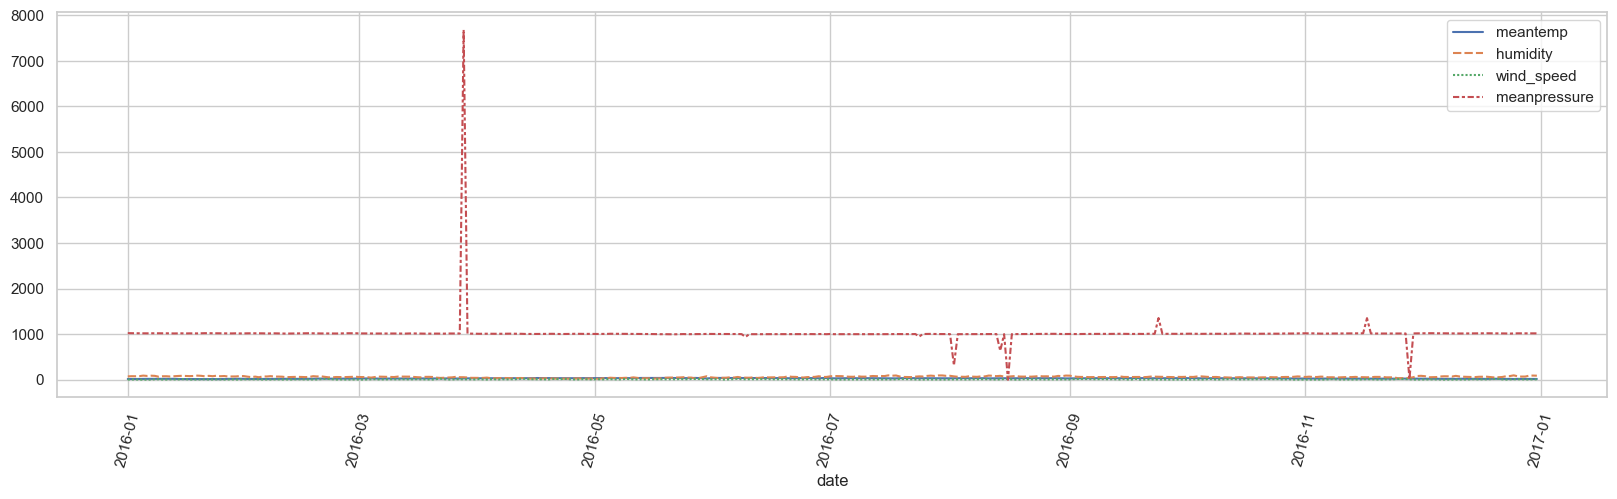

In [27]:
trazar(DATOS['weather-delhi'], rotacion=75, desde='01/01/2016', hasta='31/12/2016')

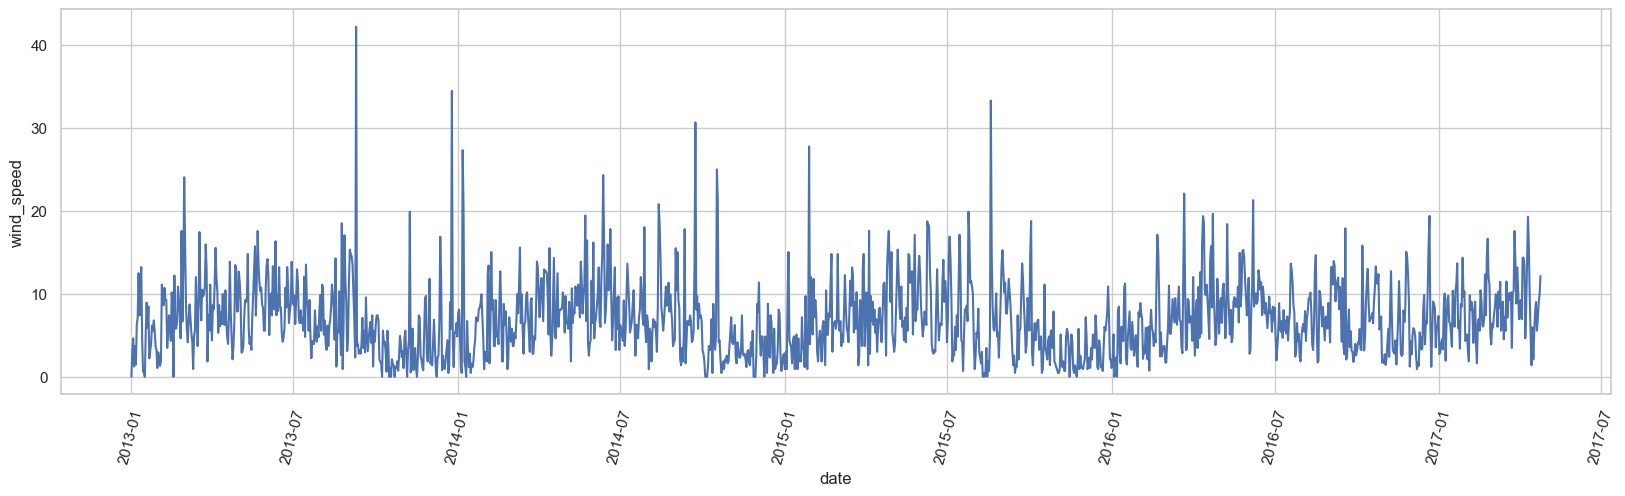

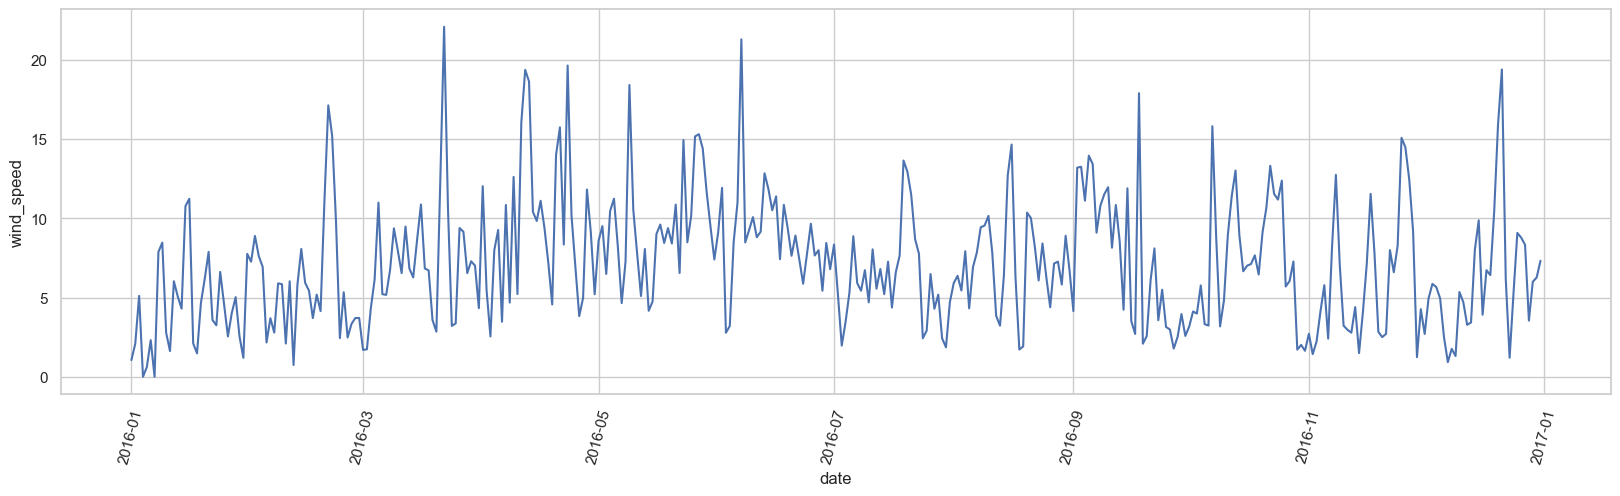

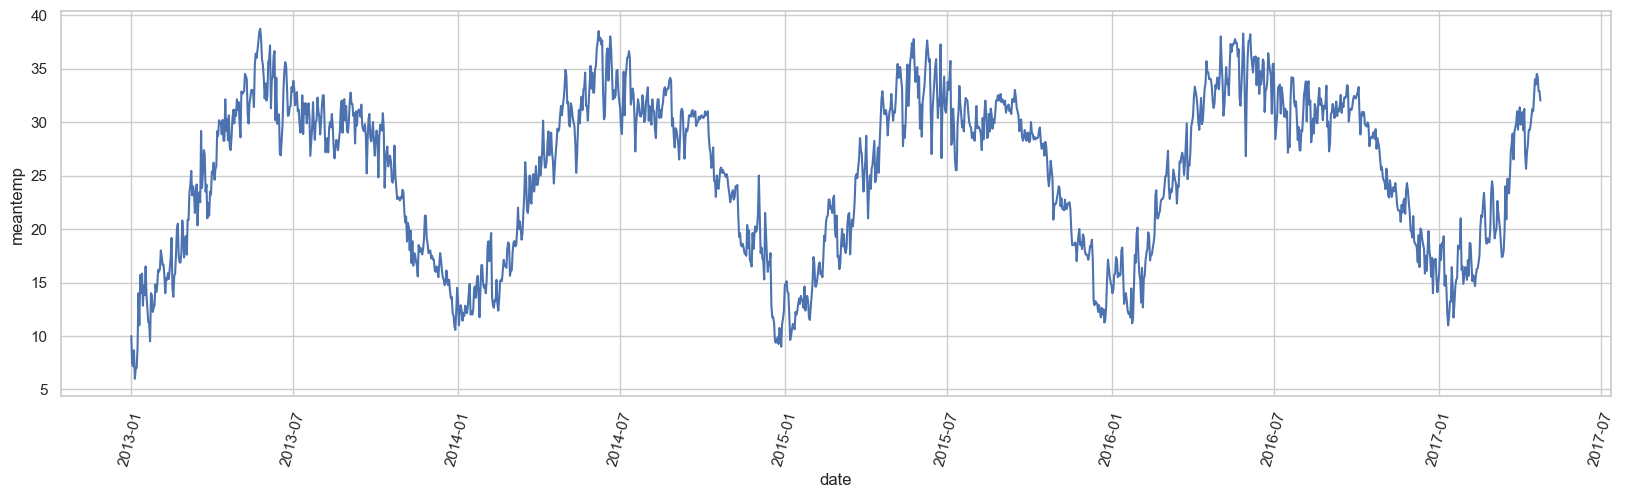

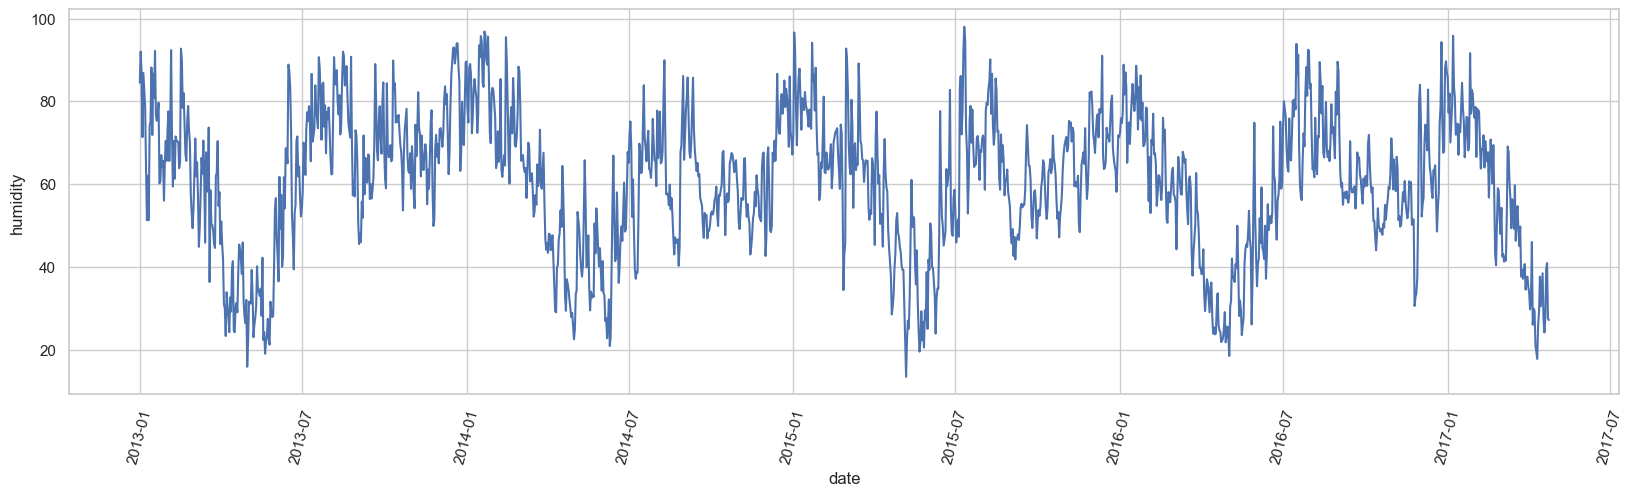

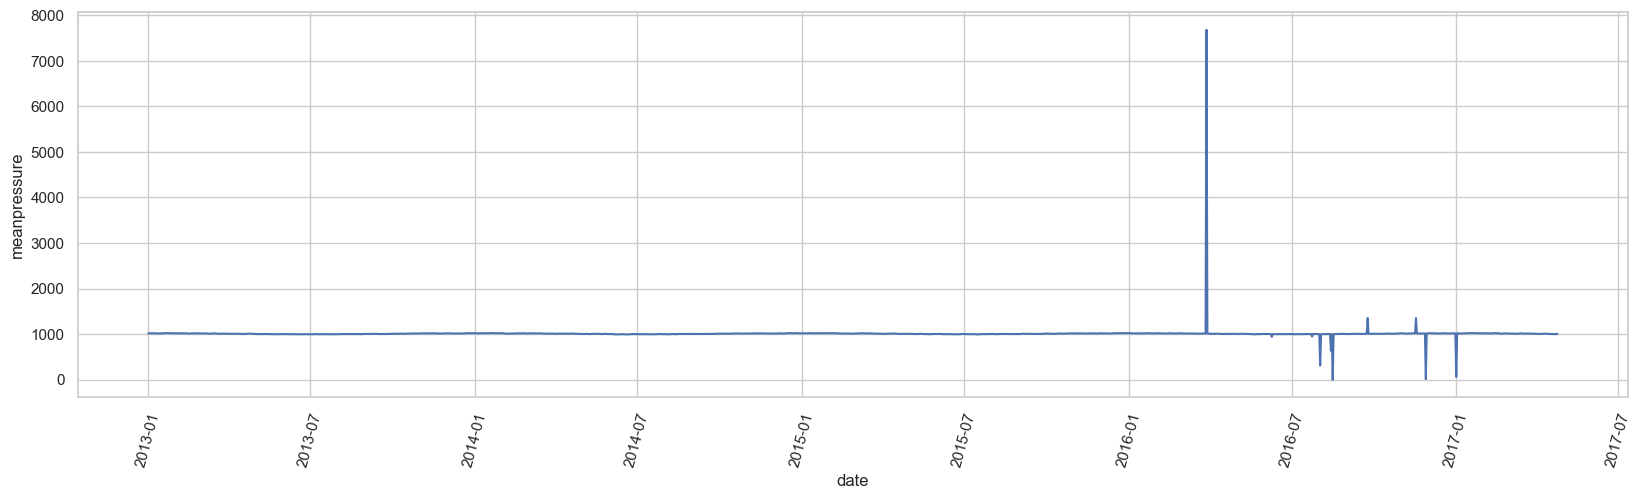

In [28]:
# TEST de 'trazar'
trazar(DATOS['weather-delhi']['wind_speed'], rotacion=75)
trazar(DATOS['weather-delhi']['wind_speed'], rotacion=75, desde='01/01/2016', hasta='31/12/2016')
trazar(DATOS['weather-delhi'], rotacion=75, desde='01/01/2016', hasta='31/12/2016')

trazar(DATOS['weather-delhi']['meantemp'], rotacion=75)
trazar(DATOS['weather-delhi']['humidity'], rotacion=75)
trazar(DATOS['weather-delhi']['meanpressure'], rotacion=75)

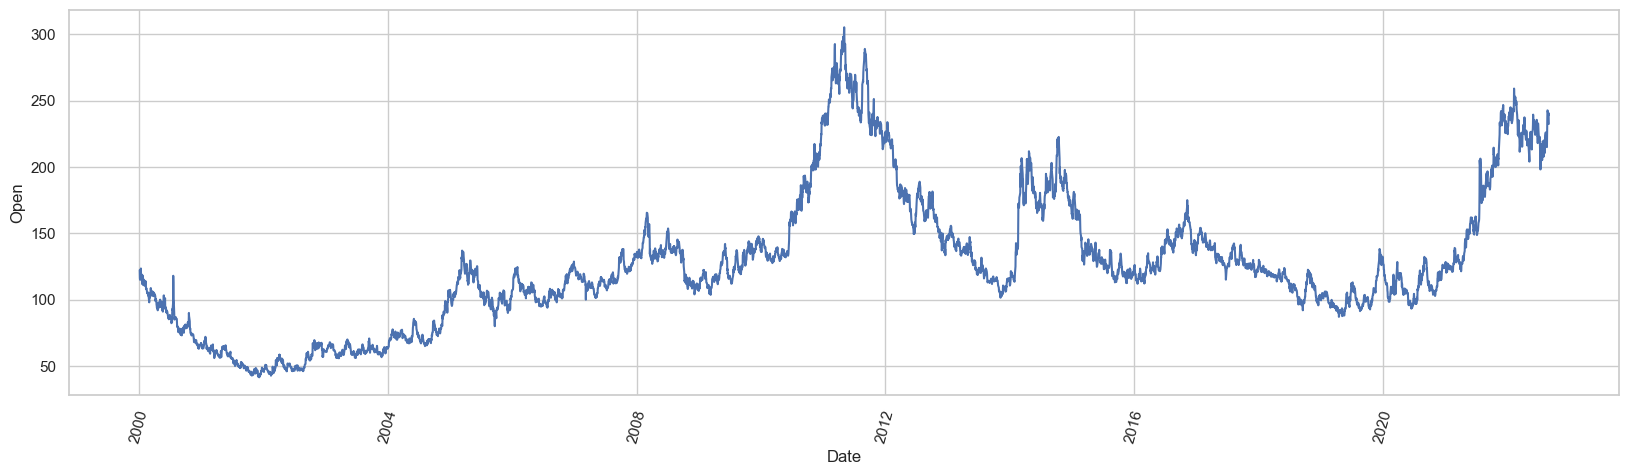

In [29]:
# EJERCICIO: Visualiza la series del resto de dataset haciendo uso de la función trazar
trazar(DATOS['coffee-price']['Open'], rotacion=75)
# Close, Volume ... other datasets

### 2.2. Tendencia y estacionalidad

En muchas series hay un componente estacional, que va variando cíclicamente a lo largo del tiempo. El caso más claro es el de las series que dependen de la época del año. Hay muchos paquetes que realizan el trabajo de descomponer una serie en diferentes componentes. Uno de ellos es <code>statsmodel</code> que permite descomponer una serie $S$ en tres componentes: tendencia ($T$), estacionalidad ($E$) y residuo ($R$). Esta descomposición puede ser adtitiva ($S=T+E+R$) o muliplicativa ($S=T*E*R$). 

In [35]:
# EJERCICIO: descomponer aditivamengte la serie 'demand' del dataset 'electricity-price' en tres 
# series 'tendencia', 'estacionalidad' y 'residuo' haciendo uso de la función seasonal_decompose:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
decomp = seasonal_decompose(DATOS['bitcoin-usd']['Adj Close'], model='additive', period=365)
decomp = seasonal_decompose(DATOS['coffee-price']['Volume'], model='additive', period=365)

tend = decomp.trend
est = decomp.seasonal
res = decomp.resid

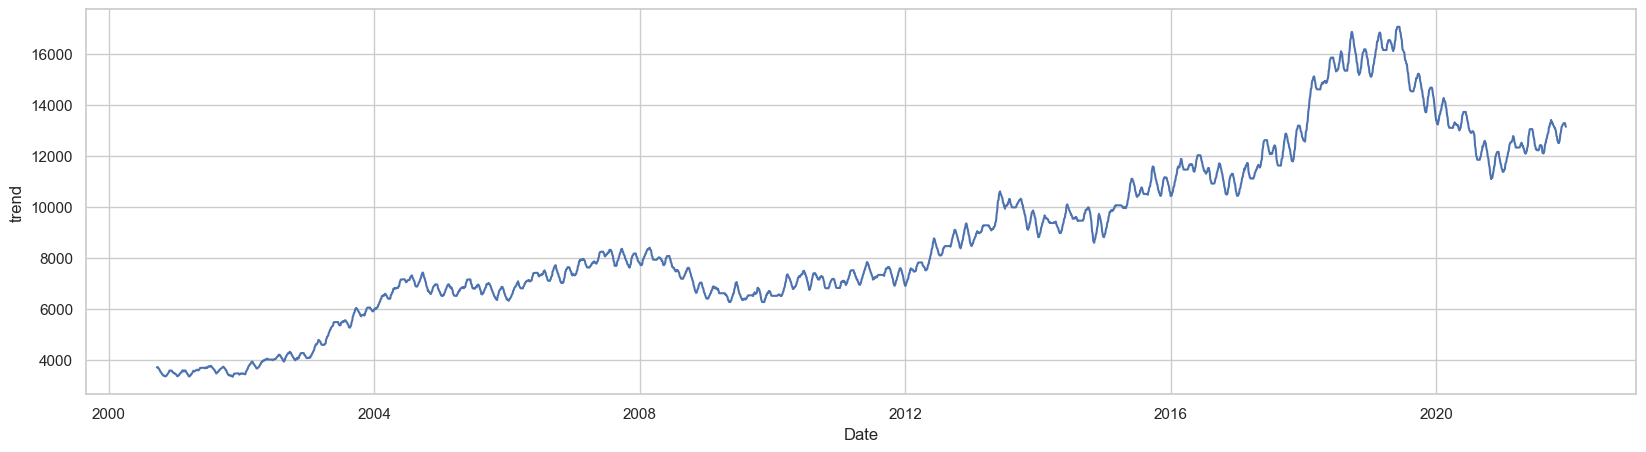

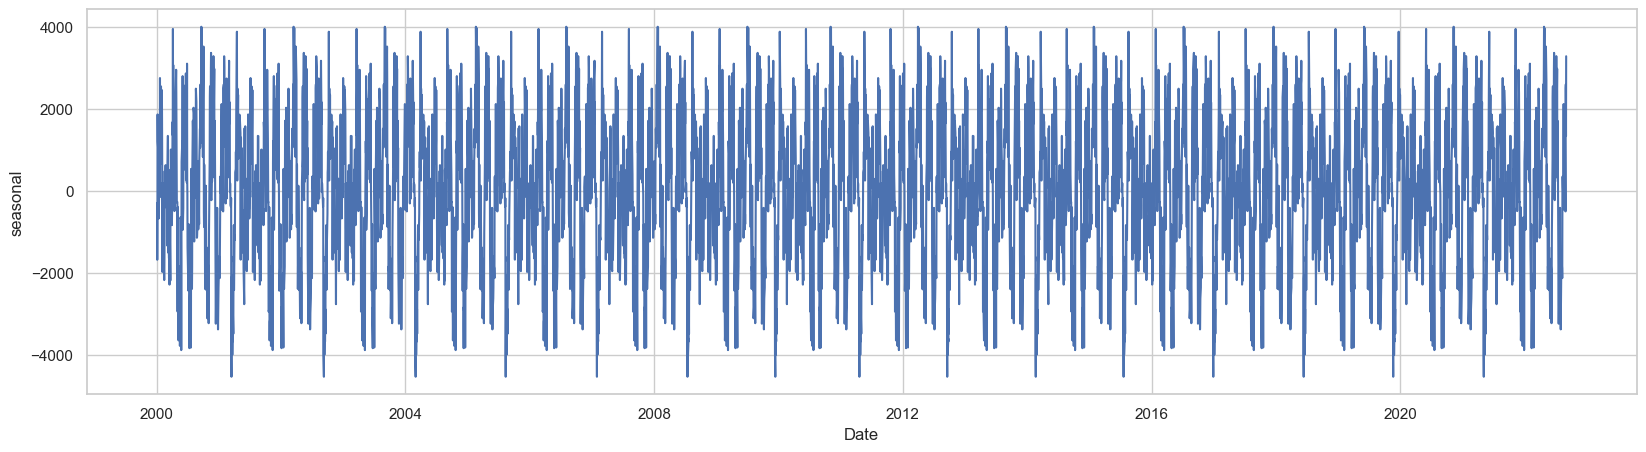

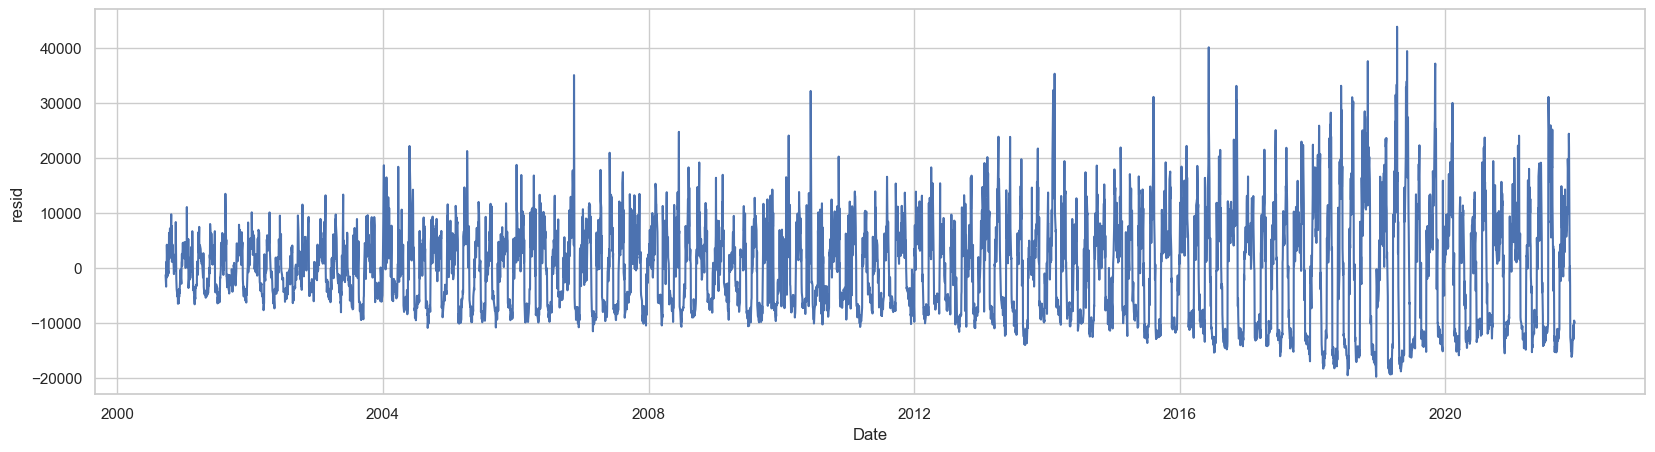

In [36]:
# TEST de la descomposición anterior
trazar(tend)
trazar(est)
trazar(res)

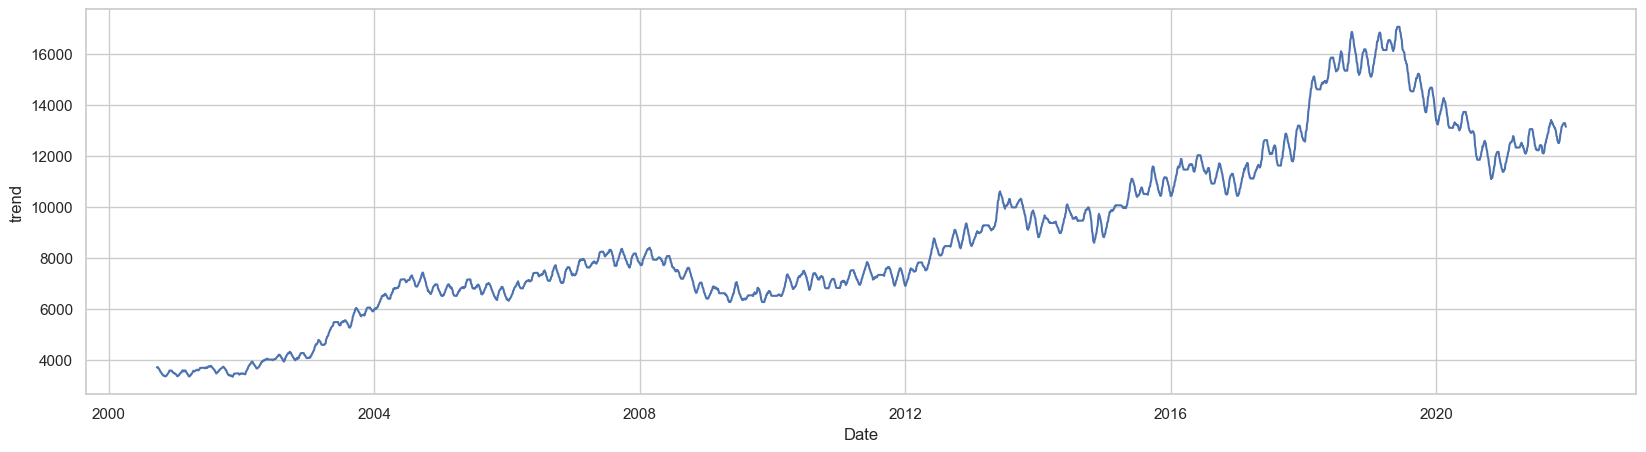

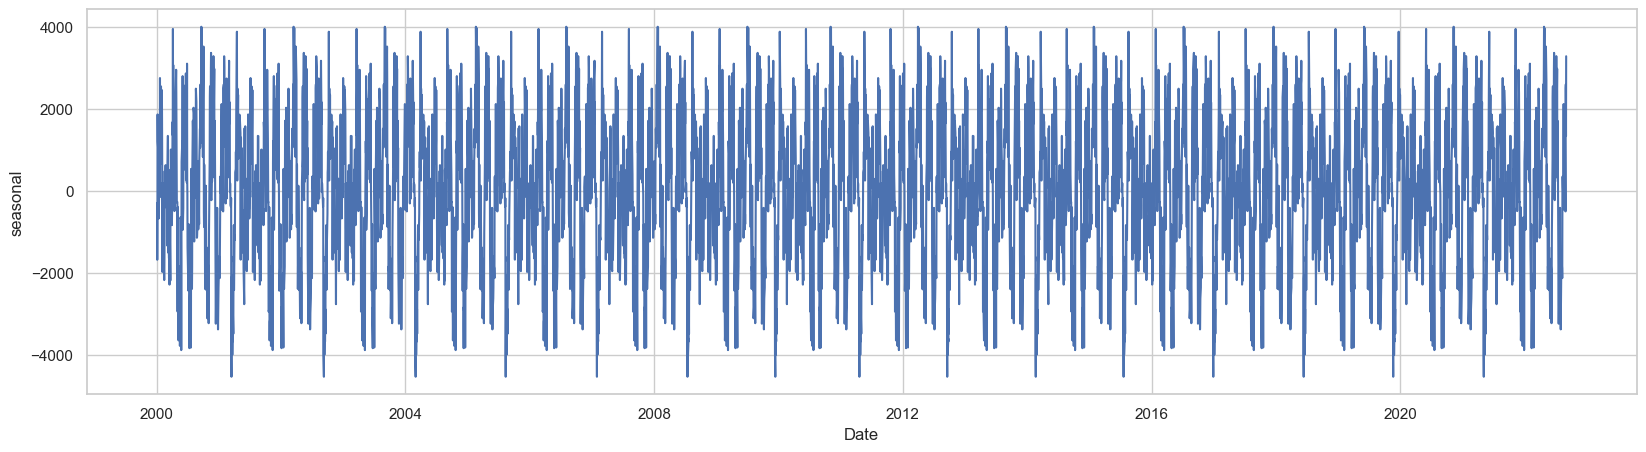

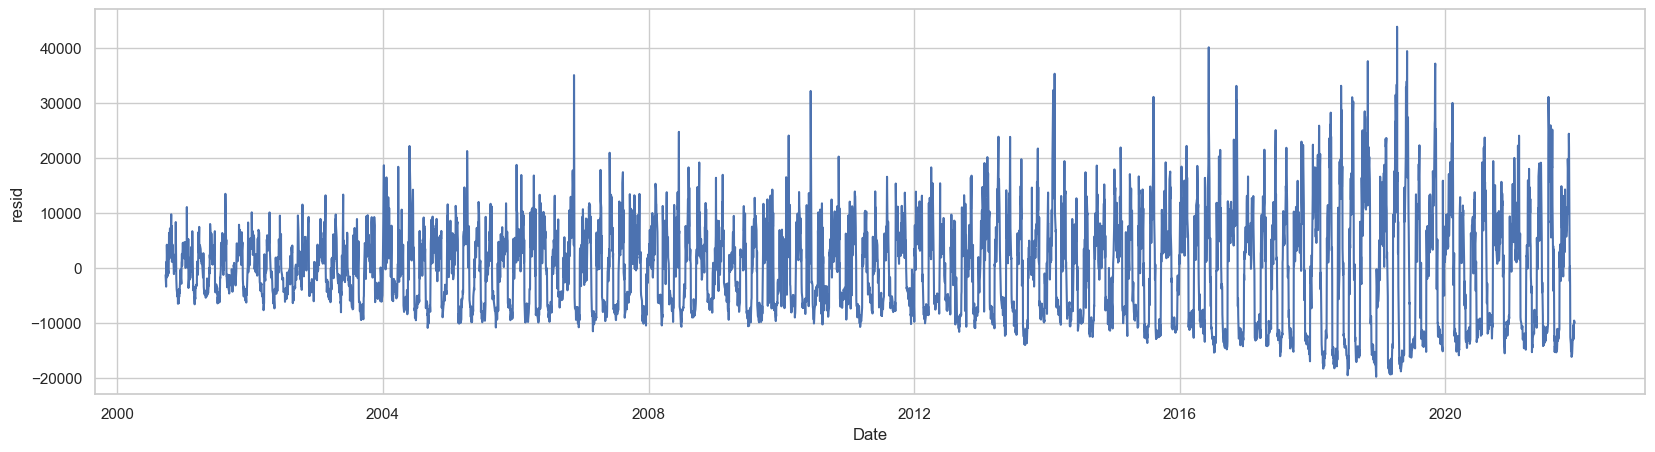

In [37]:
# EJERCICIO: repetir el análisis anterior con la serie 'Adj Close' del dataset 'bitcoin' con un modelo multiplicativo
decomp = seasonal_decompose(DATOS['bitcoin-usd']['Adj Close'], model='multiplicative', period=365)
trazar(tend)
trazar(est)
trazar(res)

### 2.3. Estacionariedad

La estacionariedad es algo distinto a la estacionalidad, de hecho hasta cierto punto se puede decir que son contrarias. Una serie estacionaria es aquella que presenta una media y una variabilidad relativamente constantes.  De esta forma, series que tengan una tendencia marcada no son estacionarias porque la media va variando. Y tampoco una serie que tenga una estacionalidad marcada puede ser estacionaria, porque en este caso su varianza cambiará con el tiempo. 

Ejemplos de **series estacionarias** son el ruido blanco, o las variaciones diarias de un valor en bolsa. Ejemplos de series **series no estacionarias** son la temperratura en una determinada ciudad, o las cotizaciones diarias de un valor en bolsa cuando se encuentra en una zona de tendencia.

La estacionariedad sirve para saber si se pueden aplicar ciertos modelos como, por ejemplo, el modelo **ARIMA**. Hay distintos paquetes que implementan tests de estacionariedad, como por ejemplo <code>statsmodels</code>. Uno de estos tests es la prueba de *Dickey-Fuller aumentada (ADF)*, valores **bajos del $pvalue$** nos permiten asumir que la serie **es estacionaria**.

In [41]:
# EJERCICIO: muestra los valores del pvalue del test ADF para las series numéricas de los datasets 'weather-delhi' y 
# 'electricity-price'
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
# statsmodels.tsa.stattools.adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[source]

res = adfuller(DATOS['weather-delhi']['meantemp'])
for c in DATOS['weather-delhi'].columns:
    if DATOS['weather-delhi'][c].dtype != 'object':
        # 1 is indice of pvalue
        pvalue = adfuller(DATOS['weather-delhi'][c].dropna())[1]
        print(f"Pvalue of {c}: {pvalue:.3f}")

print("electricity-price:")
for c in DATOS['electricity-price'].columns:
    if DATOS['electricity-price'][c].dtype != 'object':
        # 1 is indice of pvalue
        pvalue = adfuller(DATOS['electricity-price'][c].dropna())[1]
        print(f"Pvalue of {c}: {pvalue:.3f}")

Pvalue of meantemp: 0.149
Pvalue of humidity: 0.005
Pvalue of wind_speed: 0.001
Pvalue of meanpressure: 0.000
Pvalue of demand: 0.002
Pvalue of RRP: 0.000
Pvalue of demand_pos_RRP: 0.002
Pvalue of RRP_positive: 0.000
Pvalue of demand_neg_RRP: 0.046
Pvalue of RRP_negative: 0.000
Pvalue of frac_at_neg_RRP: 0.099
Pvalue of min_temperature: 0.017
Pvalue of max_temperature: 0.016
Pvalue of solar_exposure: 0.112
Pvalue of rainfall: 0.000


## 3. Preprocesado <a name="preprocesado">

Como en cualquier otro dataset, en las series temporales siempre hay posibilidad de mejorar la capacidad predictiva de los datos realizando algún tipo de preprocesado. En esta sección veremos varias técnicas de preprocesado. Algunas de ellas son genéricas y pueden aplicarse a muchos conjuntos de datos, y otras son específicas para dar respuesta a una particularidad concreta de un determinado conjunto de datos.

### 3.1. Valores ausentes y posibles errores 

Los valores ausentes son uno de los problemas de calidad más frecuentes de los datasets. A diferencia de los datasets tabulares, en las series temporales hay información suficiente como para calcular unos valores sustitutivos de bastante calidad. Se puede usar, por ejemplo, una interpolación lineal para poder llenar los huecos de datos, siempre y cuando no sean muchos los huecos y haya contexto suficiente. <code>Pandas</code> proporciona varios métodos para rellenar huecos en series temporales, entre ellos el de interpolación.

In [42]:
# Ejemplo de pequeño dataset con datos ausentes
ausentes = pd.DataFrame({'interior': [1,2,3,5,4,3,np.nan,np.nan,9,8,10,np.nan,11,9,12,14,13,14,15],
                         'extremo': [np.nan,3,4,6,5,4,7,9,10,9,11,13,12,10,13,15,14,15,np.nan]})

In [43]:
# EJERCICIO: rellenar los valores ausentes de las series disponibles en el dataset 'ausentes' y crear un dataset 'rellenos'
# en el que los huecos se han rellenado con el método correspondiente de interpolación que propoorciona Pandas.
rellenos = pd.DataFrame()
for c in ausentes.columns:
    rellenos[c] = ausentes[c].interpolate()

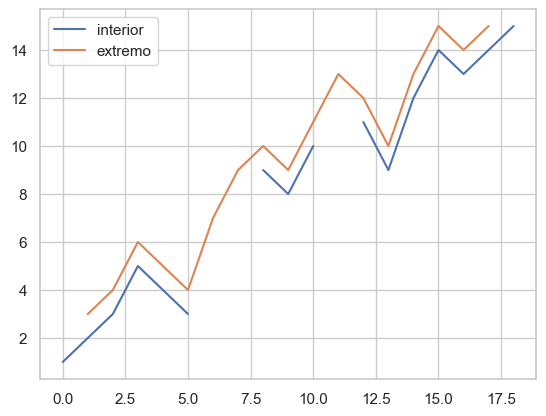

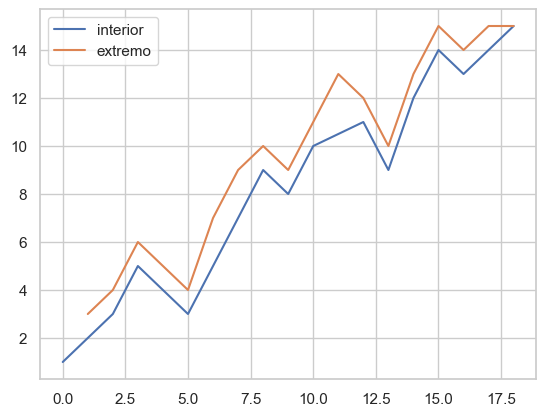

In [44]:
# TEST del ejercicio anterior:
ausentes.plot()
plt.show()

rellenos.plot()
plt.show()

In [45]:
# Como se puede observar, hay valores ausentes en algunas series del data set electricity-price
for d in DATOS:
    print(DATOS[d].info())
# electricity has missing values rainfall and solar_exposure

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1575 entries, 2013-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1575 non-null   float64
 1   humidity      1575 non-null   float64
 2   wind_speed    1575 non-null   float64
 3   meanpressure  1575 non-null   float64
dtypes: float64(4)
memory usage: 61.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2016-10-20 to 2023-10-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2557 non-null   float64
 1   High       2557 non-null   float64
 2   Low        2557 non-null   float64
 3   Close      2557 non-null   float64
 4   Adj Close  2557 non-null   float64
 5   Volume     2557 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 139.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2015

In [53]:
# EJERCICIO: aplicar interpolación para sustituir los valores ausentes del dataset 'electricity-price'
# en DATOS, los cambios deben quedar reflejados en los propios datasets en DATOS
for columna in DATOS['electricity-price'].columns:
    DATOS['electricity-price']['solar_exposure'] = DATOS['electricity-price']['solar_exposure'].interpolate(method='linear', limit_direction='both')
 
for columna in DATOS['electricity-price'].columns:
    DATOS['electricity-price']['rainfall'] = DATOS['electricity-price']['rainfall'].interpolate(method='linear', limit_direction='both')


In [54]:
# TEST del ejercicio anterior
print(DATOS['electricity-price'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2015-01-01 to 2020-10-06
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   demand           2106 non-null   float64
 1   RRP              2106 non-null   float64
 2   demand_pos_RRP   2106 non-null   float64
 3   RRP_positive     2106 non-null   float64
 4   demand_neg_RRP   2106 non-null   float64
 5   RRP_negative     2106 non-null   float64
 6   frac_at_neg_RRP  2106 non-null   float64
 7   min_temperature  2106 non-null   float64
 8   max_temperature  2106 non-null   float64
 9   solar_exposure   2106 non-null   float64
 10  rainfall         2106 non-null   float64
 11  school_day       2106 non-null   object 
 12  holiday          2106 non-null   object 
dtypes: float64(11), object(2)
memory usage: 230.3+ KB
None


Otro fenómeno fácilmente solventable es el de los puntos fuera de rango. Llaman mucho la atención en las gráficas y en la mayor parte de los casos son achacables a errores en la recogida de datos. Daremos a estos puntos la siguiente solución sencilla:
- Identificarlos y sustituirlos por <code>np.nan</code>
- Rellenar estos valores ausentes _inducidos_ mediante el método de interpolación

Para identificar estos puntos usaremos una técnica basada en los $zscores$. Este indicador se calcula el número de desviaciones típicas que un valor dado toma con respecto a la media de la muestra. Se suele determinar que un valor de una serie es anómalo cuando el valor absoluto de su $zscore$ supera un determinado umbral, por ejemplo 3. Hay muchos paquetes que proporcionan una implementación de $zscore$, uno de ellos es <code>Scipy</code>.

In [55]:
# EJERCICIO: definir la función 'suavizar_outliers' que reciba como parámetro uma serie y un umbral para zscore, y 
# sustituya los valores anómalos encontrados por una interpolación de los valores adyacentes. Esto se podrá hacer
# siguiendo los siguientes pasos:
#  - Crear un DataFrame 'df' con una columna 'serie' que contenga una copia de la serie de entrada
#  - Calcular una columna 'zscore' para el DataFrame 'df' con el valor absoluto del zscore de las correspondientes filas
#  - Sustituir con np.nan aquellos valores de la columna 'serie' cuyo 'zscore' sea mayor o igual que 'umbral_zscore'
#  - Calcular, mediante interpolación, nuevos valores para las filas de la columna 'serie' que contengan np.nan
#  - Devolver la columna df['serie']
def suavizar_outliers(datos, umbral_zscore=3):
    # serie = datos
    # for col in serie.columns:
    #     serie[f"zscore_{col}"] =  
    df = pd.DataFrame({'serie':datos})
    df['zscore'] = stats.zscore(datos).abs()
    df.loc[df['zscore'] >= umbral_zscore, 'serie'] =np.nan
    df.interpolate(method='linear', inplace=True)
    return df['serie']

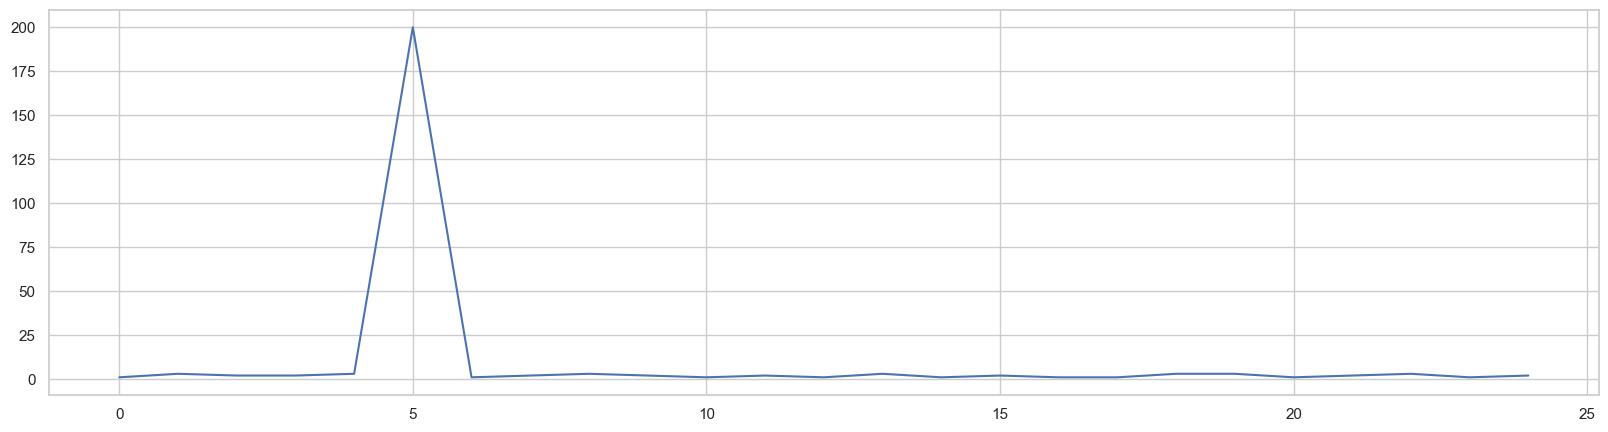

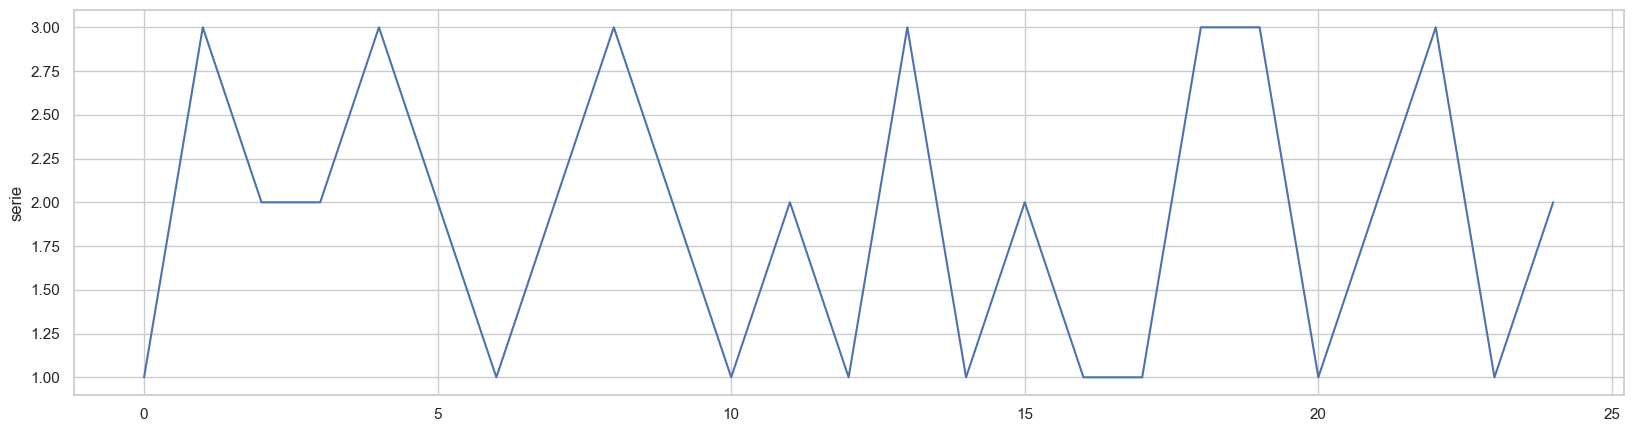

In [56]:
# TEST de la función 'suavizar_outliers'
serie = pd.Series([1, 3, 2, 2, 3, 200,1,2,3,2,1,2,1,3,1,2,1,1,3,3,1,2,3,1,2])
serie_suavizada = suavizar_outliers(serie)
trazar(serie)
trazar(serie_suavizada)

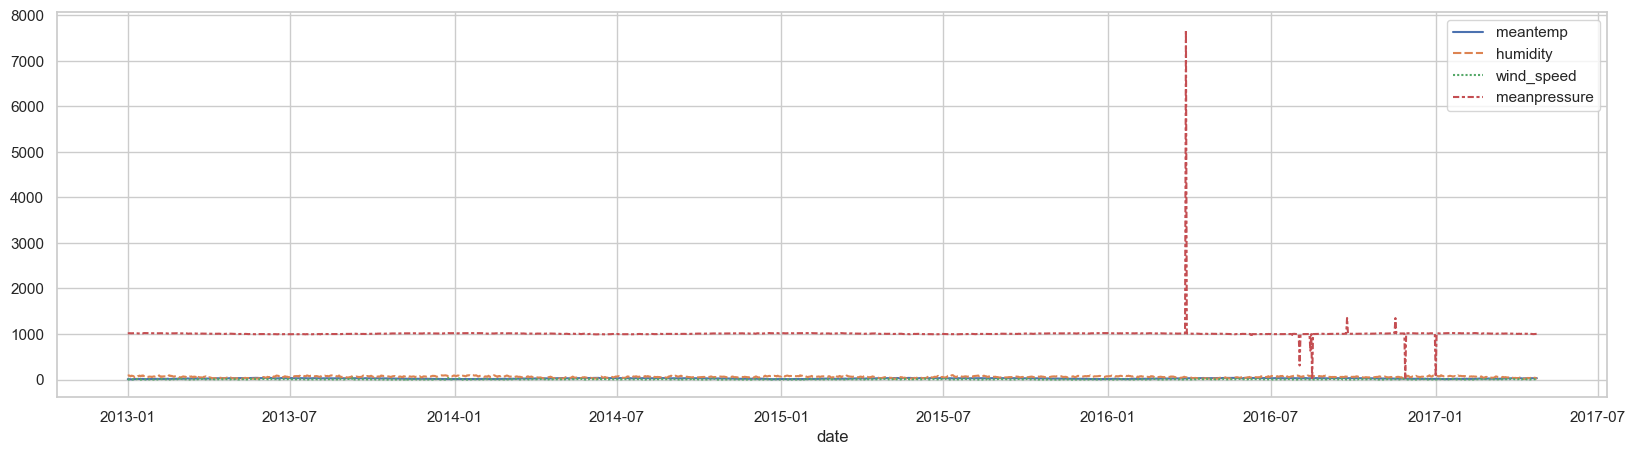

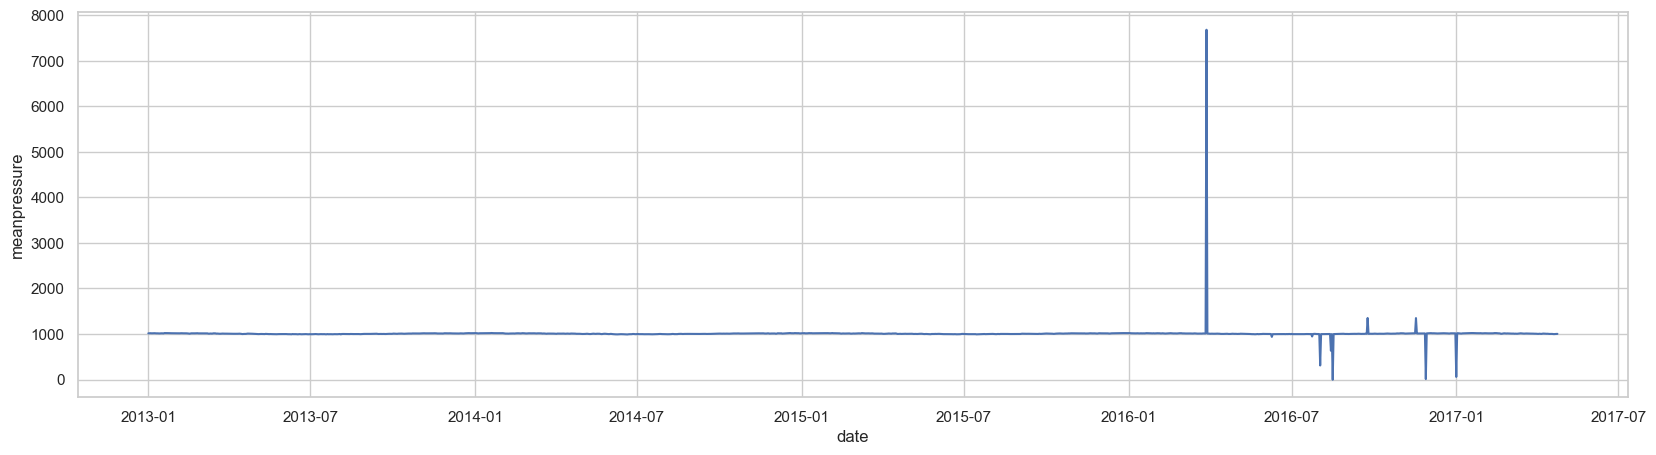

In [57]:
# El dataset 'weather-delhi' presenta claramente valores extremos
trazar(DATOS['weather-delhi'])
trazar(DATOS['weather-delhi']['meanpressure'])

In [58]:
# EJERCICIO: aplicar la función 'suavizar_outliers' para sustituir los valores anómalos de todos los datasets en DATOS, los cambios
# deben quedar reflejados en los propios datasets en DATOS
for ds in DATOS:
    for col in DATOS[ds].columns:
        if DATOS[ds][col].dtype != ' object':
            DATOS[ds][col] = suavizar_outliers(DATOS[ds][col]).values

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
# TEST del ejercicio anterior
trazar(DATOS['weather-delhi'])
trazar(DATOS['weather-delhi']['meanpressure'])

### 3.2. Remuestreo
En ocasiones los datasets de series temporales presentan un nivel de detalle demasiado fino. Para bajar ese nivel de detalle, por ejemplo de días a semanas, se aplica una técnica denominada remuestreo. <code>Pandas</code> proporciona una implementación bastante versátil de esta técnica a través del método <code>resample</code>.

In [59]:
# EJERCICIO: remuestrear la serie diaria 'Close' del dataset 'coffee-prices' en semanas, quincenas, meses y años. Y
# guardar las respectivas series en las variables 'semanal', 'mensual', 'trimestral' y 'anual'
semanal = DATOS['coffee-price']['Close'].resample('W-MON').mean()
mensual = DATOS['coffee-price']['Close'].resample('M').mean()
trimestral = DATOS['coffee-price']['Close'].resample('Q').mean()
anual = DATOS['coffee-price']['Close'].resample('A').mean()

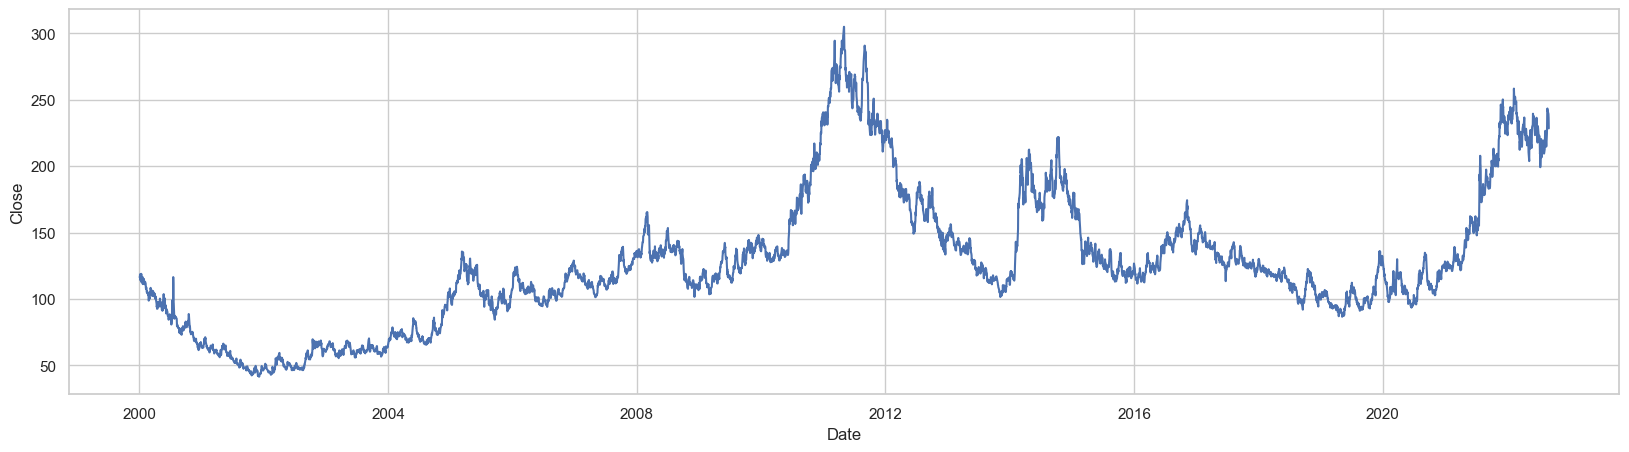

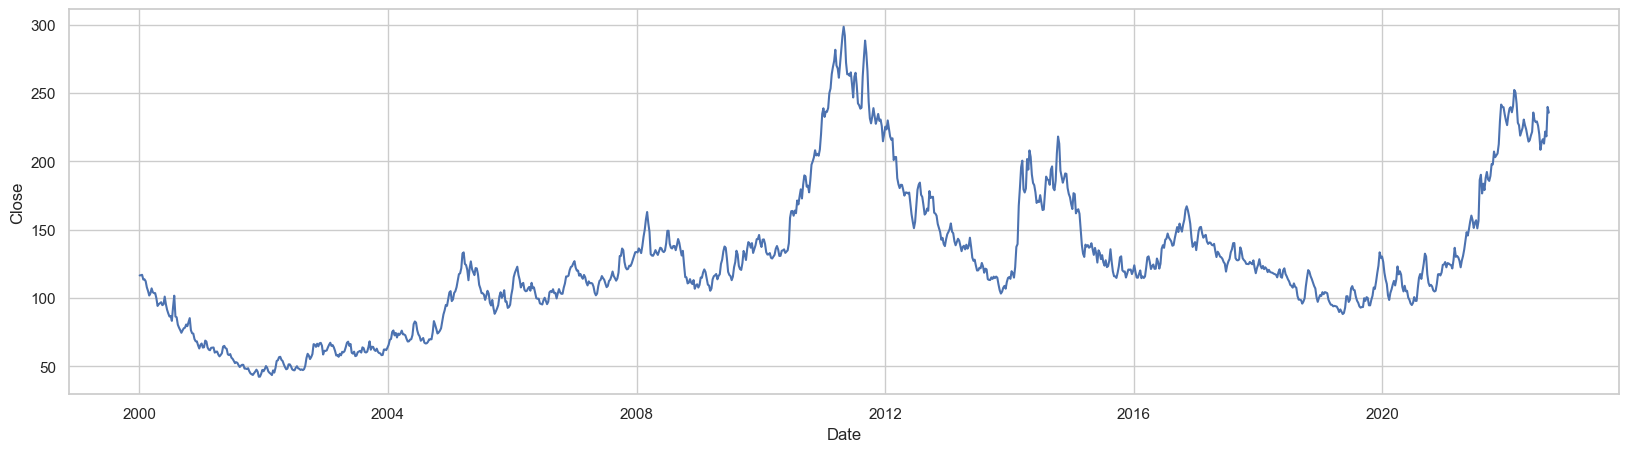

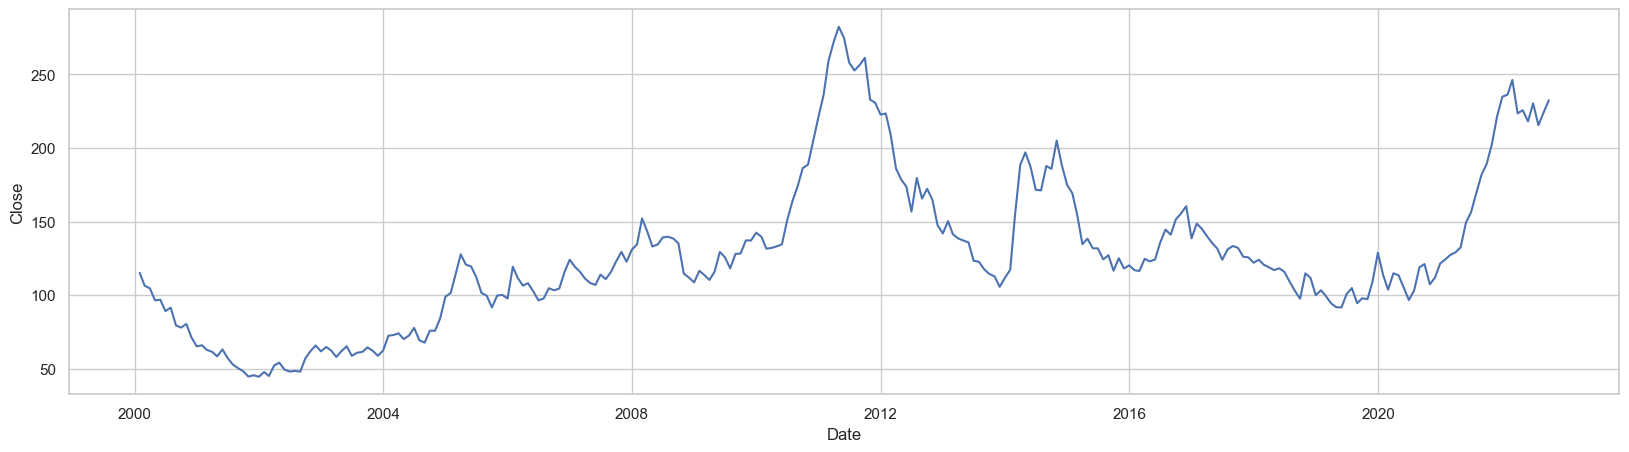

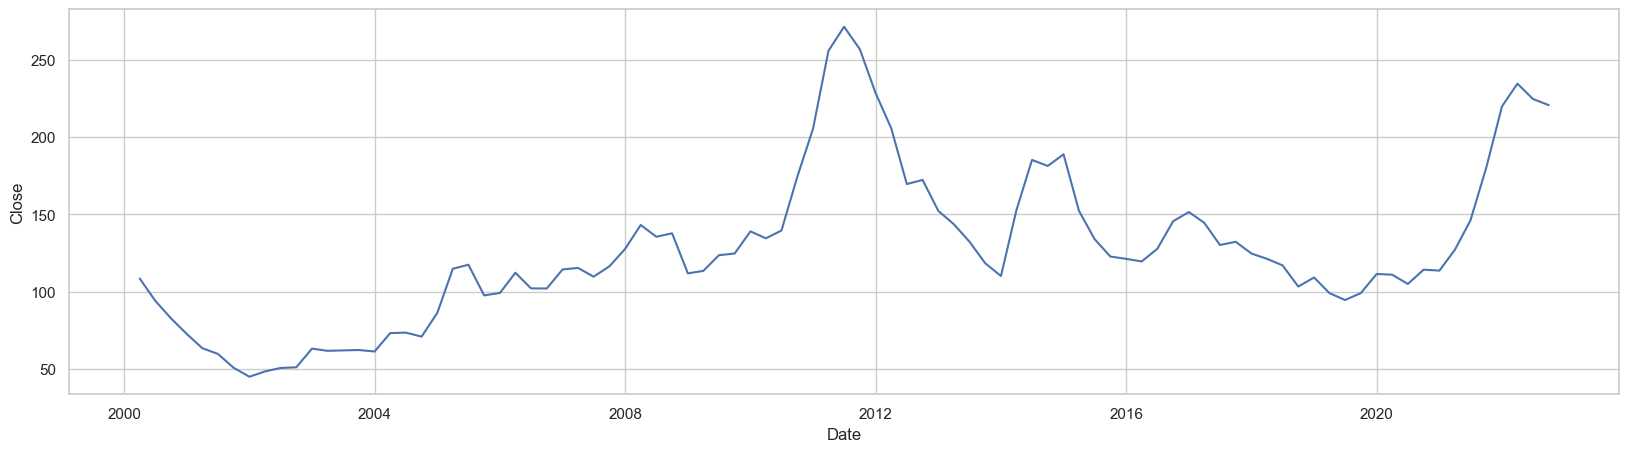

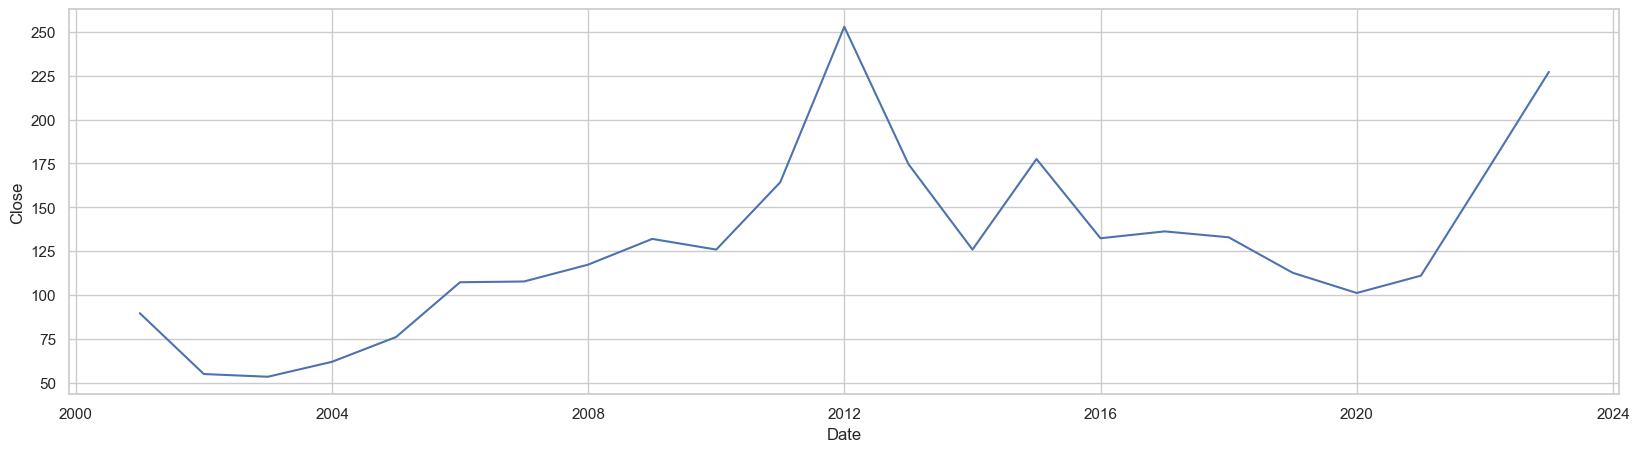

In [60]:
# TEST del ejercicio anterior:
trazar(DATOS['coffee-price']['Close'])
trazar(semanal)
trazar(mensual)
trazar(trimestral)
trazar(anual)

### 3.3. Media móvil 
La media móvil permite obtener una señal menos ruidosa, al suavizar las oscilaciones mediante el cálculo de la media sobre una ventana de valores de una determinada amplitud. Cuanto mayor sea la ventana, más suave será el resultado de la media móvil. <code>Pandas</code> proporciona el método <code>rolling</code> para generar las ventanas, sobre las que se pueden aplicar un método de agregación. Por ejemplo, <code>mean</code> para la media o <code>std</code> para la desviación estándar.

In [61]:
# EJERCICIO: calcula las variables 'media_movil_30' y 'media_movil_90' que contengan las respectivas medias sobre los 1.000 últimos valores 
# de la serie 'Close' del dataset 'bitcoin-usd'
# Done over the last 1000 data points to view properly
media_movil_30 = DATOS['bitcoin-usd'][-1000:]['Close'].rolling(30).mean()
media_movil_90 = DATOS['bitcoin-usd'][-1000:]['Close'].rolling(90).mean()

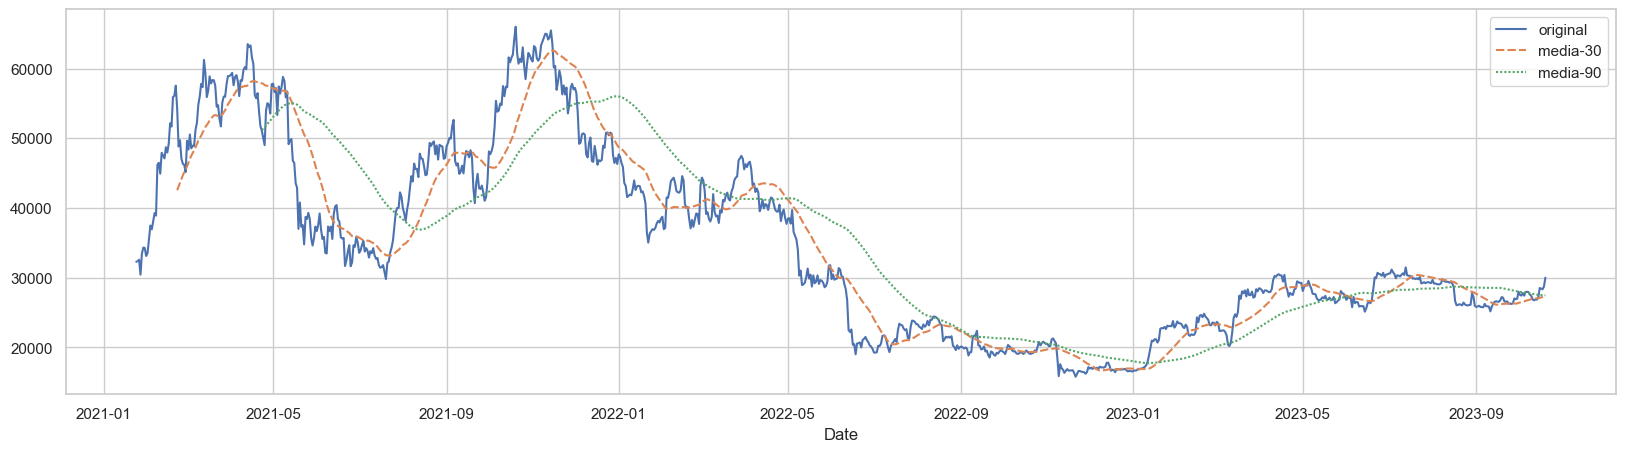

In [62]:
# TEST del ejercicio anterior
comparativa = pd.DataFrame({'original': DATOS['bitcoin-usd'][-1000:]['Close'], 'media-30': media_movil_30, 'media-90': media_movil_90})
trazar(comparativa)

In [63]:
# EJERCICIO: calcula las variables 'media_movil_30' y 'media_movil_90' de manera que se generen también valores para las primeras filas de la serie
media_movil_30 = DATOS['bitcoin-usd'][-1000:]['Close'].rolling(30, min_periods=0).mean()
media_movil_90 = DATOS['bitcoin-usd'][-1000:]['Close'].rolling(90, min_periods=0).mean()

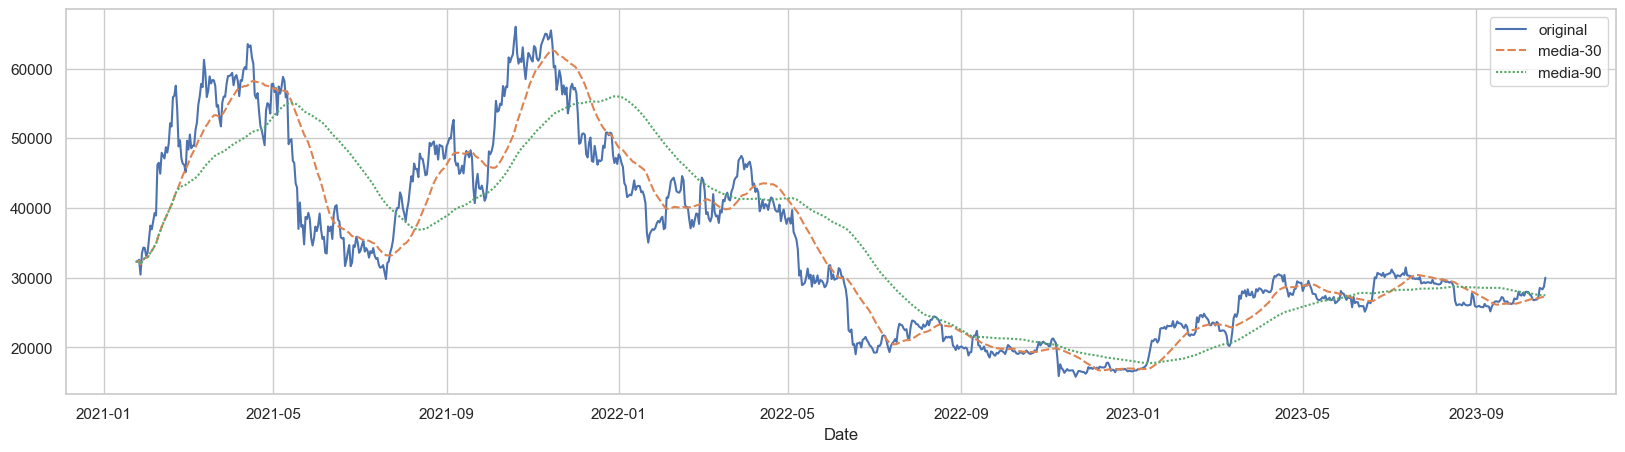

In [64]:
# TEST del ejercicio anterior
comparativa = pd.DataFrame({'original': DATOS['bitcoin-usd'][-1000:]['Close'], 'media-30': media_movil_30, 'media-90': media_movil_90})
trazar(comparativa)

### 3.4. Normalización, logaritmo y diferencia
El reescalado y normalización de los datos siempre suele ayudar, ya que permite que el entrenamiento de los modelos se concentre en las interacciones entre las distintas variables, y no en la diferencia de escalas que puedan tener. 

En las series temporales, además de las operaciones típicas de normalización (como $zscore$, $minmax$ o logaritmos) existe la posibilidad de convertir una serie de valores en una serie de diferencias con el valor anterior. En muchas ocasiones, al calcular las diferencias nos encontramos con que la nueva serie es estacionaria, a pesar de que la serie origninal no lo era. <code>Pandas</code> proporiciona el método <code>diff</code> para calcular diferencias.  

Una precaución que hay que tener a la hora de normalizar los datos de series temporales con técnicas estadísticas (p.e. $zscore$ que se basa en la media y la desviación típica) es que los estadísticos no se deben calcular usando datos globales, ya que entonces estaríamos capturando información _del futuro_. De esta forma si, por ejemplo, se necesita calcular una media debe hacerse solamente con los datos del pasado.

In [65]:
# EJERCICIO: hacer una copia del dataset 'cofee-price' en el DataFrame 'datos' y calcular las siguientes columnas
# en dicho DataFrame:
# - 'Norm - Close': normalización zscore de la columna 'Close', restando la media y dividiendo por la desviación estándar
# - 'Log - Close': normalización logarítmica de la columna 'Close'
# - 'Diff - Close': cálculo de la diferencia con respecto al valor anterior, usando 0 para el primer valor
datos = DATOS['coffee-price'].copy()
datos['Norm - Close'] = (datos['Close'] - datos['Close'].mean())/datos['Close'].std()
datos['Log - Close'] = np.log(datos['Close'])
datos['Diff - Close'] = datos['Close'].diff().fillna(0)

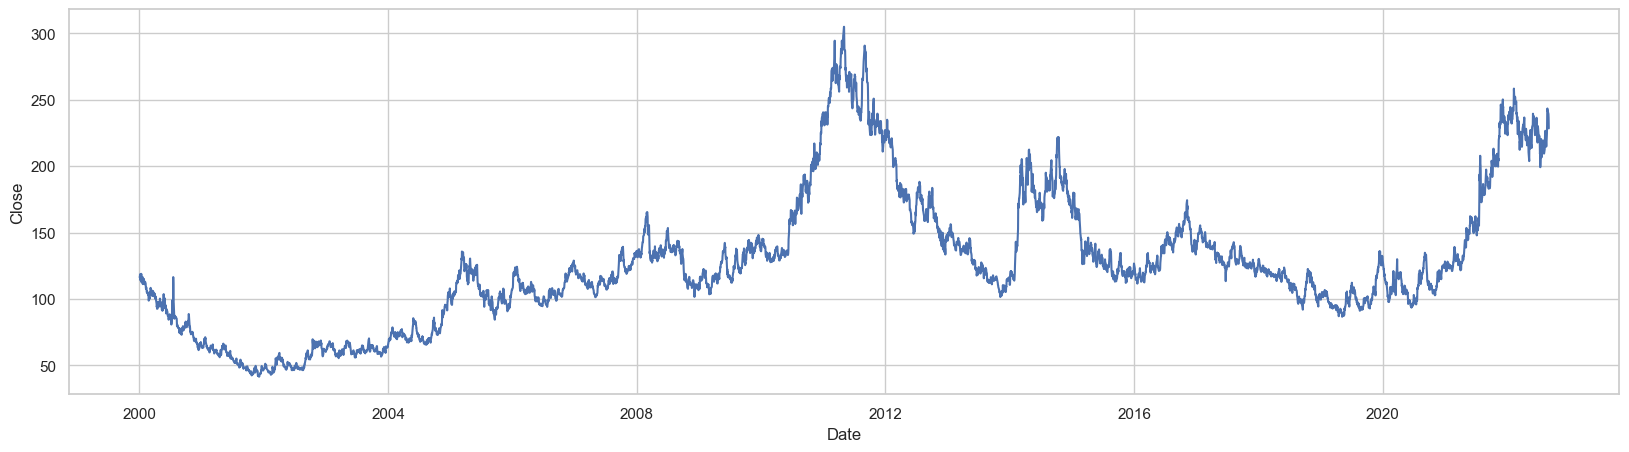

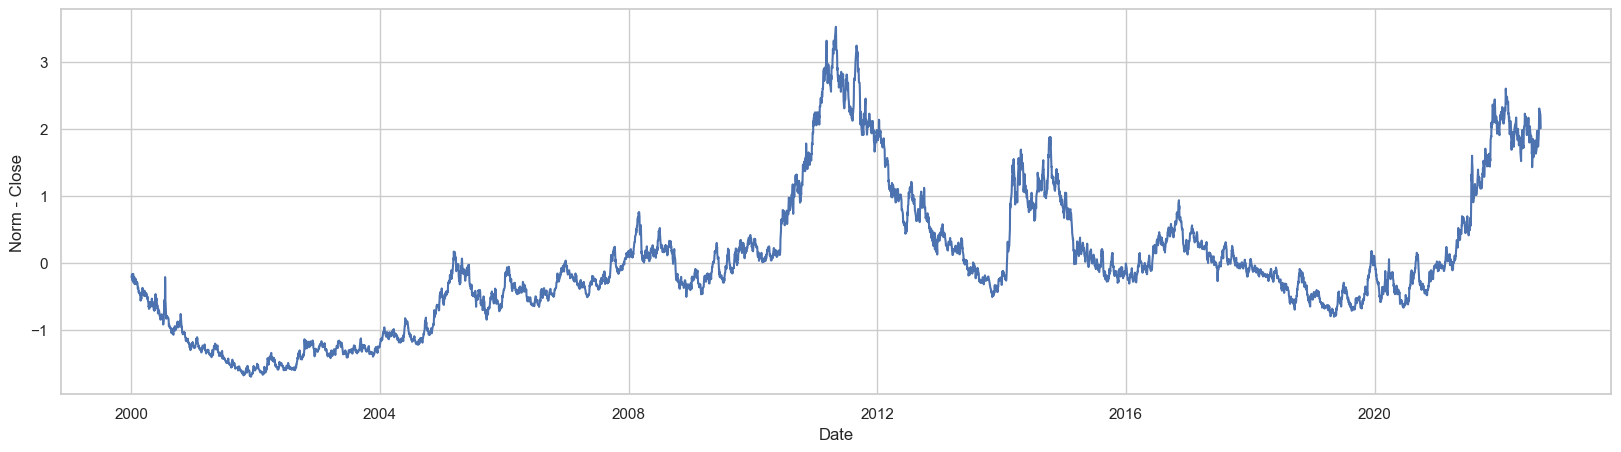

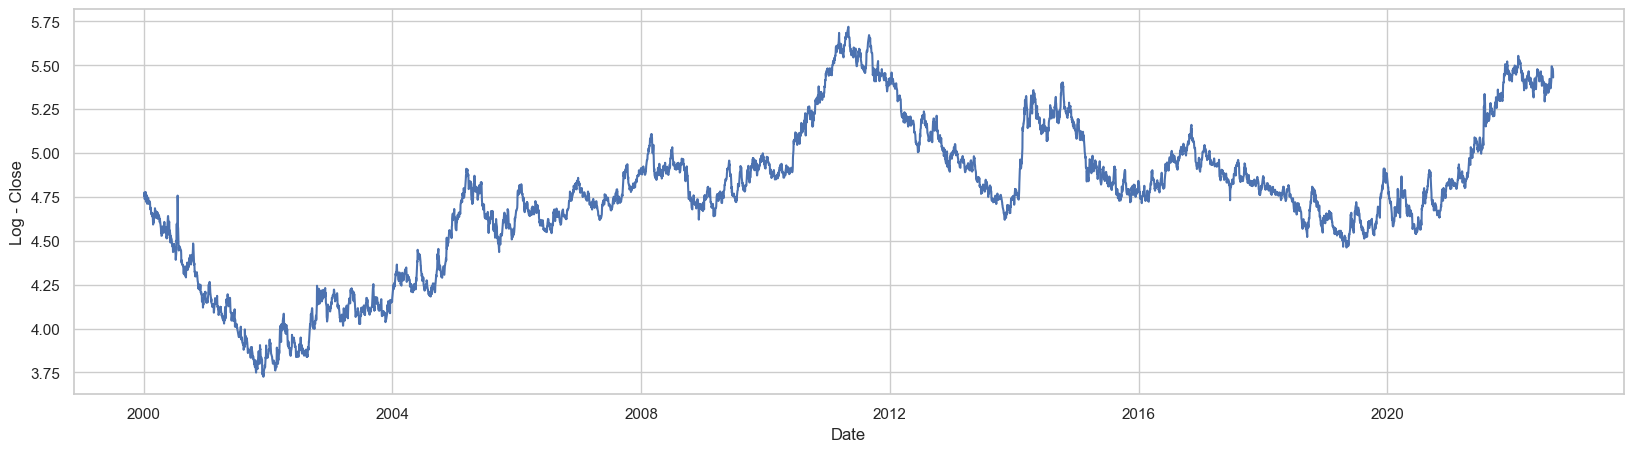

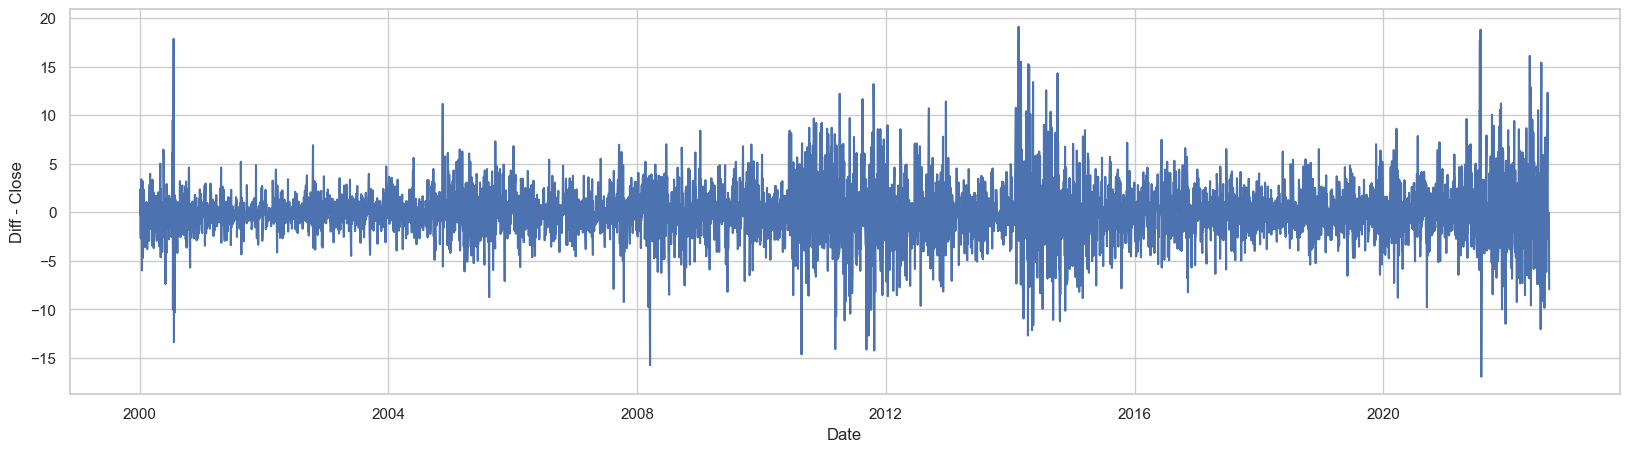

In [67]:
# TEST del ejercicio anterior
trazar(datos['Close'])
trazar(datos['Norm - Close'])
trazar(datos['Log - Close'])
trazar(datos['Diff - Close'])

In [68]:
# EJERCICIO: muestra los valores del pvalue del test ADF para las series numéricas de dataset del ejercicio anterior
for c in datos.columns:
    if datos[c].dtype != object:
        pvalue = adfuller(datos[c])[1]
        print(f"pvalue para {c}: {pvalue:.3f}")

pvalue para Open: 0.704
pvalue para High: 0.440
pvalue para Low: 0.699
pvalue para Close: 0.715
pvalue para Volume: 0.000
pvalue para Norm - Close: 0.715
pvalue para Log - Close: 0.543
pvalue para Diff - Close: 0.000


## 4. Evaluación de predicciones <a name="evaluacion"> </a>

En esta sección veremos las métricas más comunes para evaluar las predicciones sobre series temporales. Es importante destacar que, cuando usemos modelos de aprendizaje profundo, lo más común es que la evaluación se integre en el mismo proceso de entrenamiento de la red. De modo que solo usaremos las implementaciones de esta sección cuando generemos una predicción y queramos medir la desviación con respecto a la serie real.

Para evaluar las predicciones sobre series temporales se pueden usar métricas genéricas de regresión, o métricas específicas de informaciones indexadas temporalmente:

- **MAE**: *Mean Absolute Error*. No está normalizada, se interpreta en términos de la magnitud a predecir.
- **SMAE**: *Scaled Mean Absolute Error*. Normalización de *MAE* dividiendo por la media de los valores reales.
- **MAPE**: *Mean Absolute Percentage Error*. Está normalizada, pero da resultados poco fiables para valores reales bajos. En particular para valores iguales a cero no está definida.
- **RMSE**: *Root Mean Squared Error*. A diferencia de MAE, no trata todos los errores por igual, y da más peso a los errores grandes. No está normalizada.
- **SRMSE**: *Scaled Root Mean Squared Error*. Normalización de *RMSE* dividiendo por la media de los valores reales.
- **R2**: coeficiente de correlación de Pearson. Es una medida de dependencia lineal entre dos variables. No está normalizado.

Las definiciones formales son:

$$
MAE = \frac{1}{n}\sum{|e_t|}
$$

$$
SMAE = \frac{\sum{|e_t|}}{\sum{y_t}}
$$

$$ 
MAPE = \frac{1}{n}\sum{\frac{|e_t|}{y_t}}
$$

$$
RMSE = \sqrt{\frac{\sum{{e_t}^2}}{n}}
$$

$$
SRMSE = \frac{\sqrt{\frac{\sum{{e_t}^2}}{n}}}{\bar{y}}
$$

$$
R2 = 1 - \frac{\sum{{e_t}^2}}{\sum{(y_t-\bar{y})^2}}
$$

Las dos mejores candidatas, por ofrecer una medida normalizada del error, son **SMAE** y **SRMSE**.

In [ ]:
# EJERCICIO: implementa la función 'evalua_metrica' que recibe los siguientes parámetros y calcula la métrica correspondiente:
#  - y_true: valores reales
#  - y_pred: valores de la predicción
#  - metrica: métrica a evaluar. Por defecto es 'smae', pero también puede ser 'mae', 'mape', 'rmse', 'srmse' y 'r2'

# Not really covered in class - see photos on phone

In [ ]:
# TEST de la función evalua_metrica
metrica = 'smae'
print(metrica)
print(evalua_metrica([1,2,3], [1,2,3], metrica))
print(evalua_metrica([1,2,3], [1,2,2], metrica))
print(evalua_metrica([1,2,3], [3,1,2], metrica))

En el caso de las series temporales las particiones clásicas que se suelen hacer en otros conjuntos de datos con métodos como <code>train_test_split</code> no son aplicables, porque es necesario mantener el orden de la secuencia. En su lugar basta con definir un umbral de corte y dividir los datos en dos secuencias consecutivas.

In [ ]:
# Para entrenar y evaluar un modelo habitualmente los datos se depositan en dos variables X e y. 
# Por ejemplo para predecir la serie 'meantemp' del dataset 'weather-delhi' a partir del resto de series:
X = DATOS['weather-delhi'].drop(columns=['meantemp'])
y = DATOS['weather-delhi']['meantemp']

In [ ]:
# EJERCICIO: calcular una partición train-test (80%-20%) para X e y en las variables X_train, X_test, y_train, y_test.
# Mostrar los rangos de los índices (primera y última fecha) de los bloques train y test, y el número de filas de cada bloque.


Existe también la posibilidad de realizar validación cruzada, pero manteniendo el orden de los datos dentro de los bloques. <code>Sklearn</code> proporciona la clase <code>TimeSeriesSplit</code> para ello. Los bloques que se generan no son de tamaño fijo, para introducir variabilidad en cuanto a las ventanas de datos usadas para realizar predicciones.

In [ ]:
# EJERCICIO: calcular 5 particiones de X e y con TimeSeriesSplit para realizar validación cruzada. Mostrar los rangos de 
# los índices (primera y última fecha) de los bloques train y test, y el número de filas de cada bloque.


## 5. Creación de ventanas de datos <a name="ventanas"> </a>

Para poder aplicar _machine learning_ sobre series temporales, hay que construir un dataset a partir de las series de entrada. Este proceso implica definir registros que incluyan una ventana de valores pasados de una misma serie, para poder capturar la historia reciente a la hora de realizar una predicción. Se suele denominar _windowing_ a este proceso, y hay varias alternativas para realizarlo.  En este _notebook_ usaremos la solución que propone TensorFlow en su propia <a href='https://www.tensorflow.org/tutorials/structured_data/time_series?hl=es-419'>documentación</a> sobre tratamiento de series temporales, en la que implementa la clase <code>WindowGenerator</code> con una serie de utilidades para la construcción y visualizaciones de tensores a partir de series de datos. La implementación de dicha clase está disponible en el módulo local <code>WindowGenerator.py</code>.

Se pueden encontrar otras soluciones de _windowing_ en algún <a href='https://medium.com/aiskunks/daily-climate-forecasting-time-series-forecasting-using-lstm-recurrent-neural-nets-bbe6f425c688'> tutorial</a>, o también en librerías específicas para el preprocesamiento de series temporales (<a href='https://github.com/logspace-ai/wavy'>Wavy</a> o <a href='https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator'>TimeseriesGenerator</a>).

Los principales parámetros del constructor de la clase <code>WindowGenerator</code> son:
- <code>train_df</code>: único parámetro obligatorio. Recibe un <code>DataFrame</code> con los datos de la partición <code>train</code>. Hay también dos parámetros opcionales <code>val_df=None</code> y <code>test_df=None</code> para las particiones <code>val</code> y <code>test</code>, respectivamente. 
- <code>input_width=1</code>: ventana de entrada. Número de unidades de tiempo a tener en cuenta como historia pasada. Por defecto <code>1</code>.
- <code>label_width=1</code> ventana de salida. Número de unidades de tiempo que componen la predicción. Por defecto <code>1</code>.
- <code>shift=1</code>: retardo, o alcance de la predicción. Diferencia de posiciones entre el último instante de tiempo de la entrada, y el último instante de tiempo de la predicción. Por defecto <code>1</code>.
- <code>label_columns=None</code>: lista de las columnas que se se van a predecir como salida. Si no se indica ninguna, se realizará la predicción de todas las columnas de los datos de entrada.


La siguiente imagen, extraída de la documentación de <code>TensorFlow</code> muestra dos ejemplos de configuraciones. La primera para realizar una predicción de tamaño 1, con una ventana pasada de 24 unidades y un retardo de 24 unidades. La segunda configuración es para realizar una predicción de tamaño 1, con una ventana pasada de 6 unidades y un retardo de 1 unidad.

<img src="img/ventanas.png" alt="Título" width="450" height="300">


Los principales atributos y métodos que nos ofrece la clase <code>WindowGenerator</code> son:
- <code>train</code>: atributo que devuelve el objeto <code>tf.data.Dataset</code> correspondiente a la partición <code>train</code>
- <code>val</code>: atributo que devuelve el objeto <code>tf.data.Dataset</code> correspondiente a la partición <code>val</code>
- <code>test</code>: atributo que devuelve el objeto <code>tf.data.Dataset</code> correspondiente a la partición <code>test</code>
- <code>make_dataset(data)</code>: método que devuelve el objeto <code>tf.data.Dataset</code> correspondiente a una partición recibida como parámetro, hace uso del método <a href='https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array'>tf.keras.utils.timeseries_dataset_from_array</a>
- <code>plot(plot_col, model=None, max_subplots=3)</code>: método que traza gráficas a partir de varias muestras de datos extraídos del primer lote de ejemplos del dataset <code>train</code>. El parámetro <code>plot_col</code> es el único obligatorio y se corresponde con la columna que va a ser trazada. El parámetro <code>max_subplots=3</code> permite indicar el número de muestras a trazar. Y el parámetro <code>model=None</code> permite mostrar, además, los puntos resultantes de la aplicación de un modelo.  

In [69]:
print(DATOS['weather-delhi'].shape)
DATOS['weather-delhi'][:5]

(1575, 4)


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [70]:
# Partición de un dataset en train-validation-test
datos = DATOS['weather-delhi']

# Proporciones: 70%-20%-10%
tamaño = len(datos)
train = datos[0:int(tamaño*0.7)]
val = datos[int(tamaño*0.7):int(tamaño*0.9)]
test = datos[int(tamaño*0.9):]

num_atributos = datos.shape[1]
print('Train:', len(train))
print('Val:', len(val))
print('Test:', len(test))
print('Atributos:', num_atributos)

Train: 1102
Val: 315
Test: 158
Atributos: 4


In [71]:
# Funciones para mostrar información de un dataset (tf.data.Dataset)
def muestra_informacion_lotes(dataset):
    print('Número de lotes:', len(dataset))
    lotes = [(inputs, targets) for inputs, targets in dataset]
    for i, (inputs, targets) in enumerate(lotes[:10]):
        print('Lote {} => forma entradas: {}, forma salidas: {}'.format(i+1, inputs.shape, targets.shape))
    ultimo_lote = lotes[-1]
    print('Último lote ({}) forma entradas: {}, forma salidas: {}'.format(len(dataset), ultimo_lote[0].shape, ultimo_lote[0].shape))

    
def muestra_informacion_tensores(dataset):
    # Forma (shape) de los elementos de 'dataset'
    element_spec = dataset.element_spec
    # Obtener la forma de cada componente en element_spec
    element_shapes = []
    for spec in element_spec:
        element_shapes.append(spec.shape)
    print(element_shapes)
    
    
def muestra_contenido_primer_elemento(dataset):
    # Contenido del primer elemento de 'dataset'
    element = next(iter(dataset))
    # Convertir los tensores a arrays de NumPy para visualizar los datos
    element_numpy = [tensor.numpy() for tensor in element]
    # Imprimir el contenido de los arrays de NumPy
    print('El elemento contiene {} tensores\n'.format(len(element_numpy)))
    for i, array in enumerate(element_numpy):
        print("Tensor {}:\n{}\n...\nShape: {}\n".format(i+1, array[0], array.shape))

In [72]:
# EJERCICIO: crea un generador de ventanas wg_7_2 con los siguientes valores
#  - 'train' es el DataFrame de la partición train
#  - 'val' es el DataFrame de la partición validation
#  - 'test' es el DataFrame de la partición test
#  - La anchura de la ventana de entrada es 7
#  - La anchura de la ventana de salida es 2
#  - El retardo es también 2
#  - La única columna de salida es 'meantemp'
# Las estadísticas del generador se mostrarán, gracias al método __repr__, haciendo que la 
# última instrucción de la celda sea 'wg_7_2' 

# We should always define a shift at least as large as the window
wg_7_2 = WindowGenerator(train_df=train, val_df=val, test_df=test, input_width=7,label_width=2,shift=7,label_columns=["meantemp"])
wg_7_2

Total window size: 9
Input indices: [0 1 2 3 4 5 6]
Label indices: [7 8]
Label column name(s): ['meantemp']

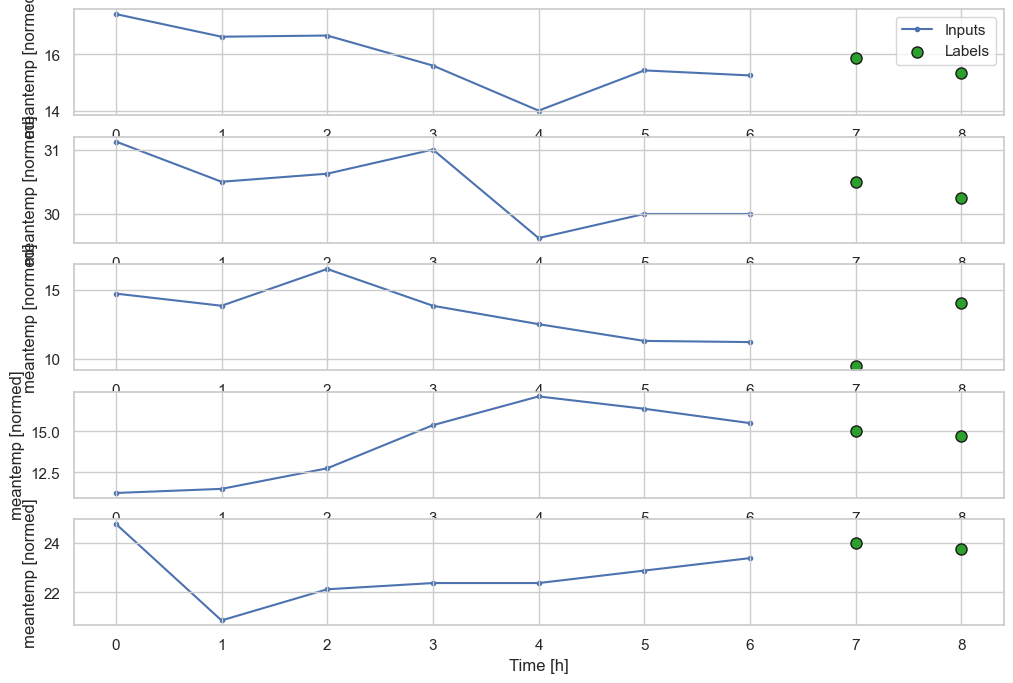

In [73]:
# EJERCICIO: mustra gráficamente varias muestras de datos extraídos del primer lote
# de ejemplos del dataset train, para el atributo 'meantemp', haciendo uso de la función
# plot de WindowGenerator

# Still not predicting anything yet
wg_7_2.plot('meantemp', max_subplots=5)

In [76]:
# EJERCICIO: Mostrar los tamaños de los lotes del dataset de train con 
# la función 'muestra_informacion_lotes', a partir del generador 'wg_7_2'. 
dataset = wg_7_2.train
# for e in dataset:
#     print(e)
muestra_informacion_lotes(dataset)

Número de lotes: 35


Lote 1 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 2 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 3 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 4 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 5 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 6 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 7 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 8 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 9 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 10 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Último lote (35) forma entradas: (6, 7, 4), forma salidas: (6, 7, 4)


En total hay 34 lotes de 32 instancias y un 1 lote con el resto de 6 instancias, dando un total de 1094 instancias en el dataset del tipo <code>MapDataset</code>. Son 8 menos del número de filas del <code>DataFrame</code> original, que se pierden para garantizar que no quedan valores <code>NaN</code> al aplicar una ventana global de 9 posiciones.

In [77]:
# EJERCICIO: muestra también la información de los lotes de los conjuntos de val y test
muestra_informacion_lotes(wg_7_2.val)
muestra_informacion_lotes(wg_7_2.test)

Número de lotes: 10
Lote 1 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 2 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 3 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 4 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 5 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 6 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 7 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 8 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 9 => forma entradas: (32, 7, 4), forma salidas: (32, 2, 1)
Lote 10 => forma entradas: (19, 7, 4), forma salidas: (19, 2, 1)
Último lote (10) forma entradas: (19, 7, 4), forma salidas: (19, 7, 4)


In [79]:
# EJERCICIO: muestra la información de los tensores del dataset de train
muestra_informacion_tensores(wg_7_2.train)

[TensorShape([None, 7, 4]), TensorShape([None, 2, 1])]


La salida de la celda anterior significa lo siguiente:
- Cada elemento del dataset contiene dos tensores:
    - El primero para las características
    - El segundo para las salidas
- Por ejemplo, <code>[None, 7, 4]</code> describe la forma de un tensor de tres dimensiones:
    - La primera dimensión (<code>None</code>) tiene longitud variable
    - La segunda dimensión es de longitud 7 (anchura de la entrada)
    - La tercera dimensión es de longitud 4 (número de características del dataset)
    
La siguiente figura muestra una representación gráfica intuitiva para un lote con formato <code>TensorShape([32, 24, 6]</code> correspondiente a 32 instancias, con 24 unidades de tiempo para 6 atributos: 

<img src="img/batch.png" alt="Título" width="600" height="400">

In [80]:
# EJERCICIO: muestra el contenido del primer elemento de 'dataset'
muestra_contenido_primer_elemento(dataset)

El elemento contiene 2 tensores

Tensor 1:
[[  33.          33.           3.2375     999.8571   ]
 [  33.          34.75         7.175      998.5      ]
 [  32.833332    28.166666     9.866667  1000.3333   ]
 [  31.4         42.2         12.966666   999.       ]
 [  35.333332    22.333334    15.75       999.6667   ]
 [  36.4         24.2          7.4        998.4      ]
 [  36.          19.          11.3714285  998.6667   ]]
...
Shape: (32, 7, 4)

Tensor 2:
[[36.75]
 [37.5 ]]
...
Shape: (32, 2, 1)



In [81]:
# EJERCICIO: crear un nuevo 'dataset' con los mismos parámetros que el de los ejercicios anteriores, pero usando
# un generador para el que no se han indicado los nombres de las columnas de salida. 
# Mostrar la información de los lotes, y de los tensores.
#
# ¿Qué ha cambiado? 
wg_7_2 = WindowGenerator(train_df=train, val_df=val, test_df=test, input_width=2, shift=2)
dataset = wg_7_2.train
muestra_informacion_lotes(dataset)
print()
muestra_informacion_tensores(dataset)
muestra_contenido_primer_elemento(dataset)


Número de lotes: 35
Lote 1 => forma entradas: (32, 2, 4), forma salidas: (32, 1, 4)
Lote 2 => forma entradas: (32, 2, 4), forma salidas: (32, 1, 4)
Lote 3 => forma entradas: (32, 2, 4), forma salidas: (32, 1, 4)
Lote 4 => forma entradas: (32, 2, 4), forma salidas: (32, 1, 4)
Lote 5 => forma entradas: (32, 2, 4), forma salidas: (32, 1, 4)
Lote 6 => forma entradas: (32, 2, 4), forma salidas: (32, 1, 4)
Lote 7 => forma entradas: (32, 2, 4), forma salidas: (32, 1, 4)
Lote 8 => forma entradas: (32, 2, 4), forma salidas: (32, 1, 4)
Lote 9 => forma entradas: (32, 2, 4), forma salidas: (32, 1, 4)
Lote 10 => forma entradas: (32, 2, 4), forma salidas: (32, 1, 4)
Último lote (35) forma entradas: (11, 2, 4), forma salidas: (11, 2, 4)

[TensorShape([None, 2, 4]), TensorShape([None, 1, 4])]
El elemento contiene 2 tensores

Tensor 1:
[[  13.833333   92.166664    8.95     1014.5     ]
 [  12.5        76.666664    5.883333 1021.6667  ]]
...
Shape: (32, 2, 4)

Tensor 2:
[[  11.2    77.      2.22 1021.  

## 6. Predicción simple <a name="un_paso"> </a>
En esta sección experimentaremos con distintos modelos para realizar predicciones a partir de una ventana pasada de 7 unidades de tiempo, y una predicción de un único paso hacia el futuro. En concreto probaremos:

- Modelo lineal
- Modelo denso
- Modelo LSTM

Evaluaremos cada experimento con los datos de entrenamiento y validación, y también mostraremos la evolución gráfica de las predicciones de algunos fragmentos del conjunto de datos.

Empezaremos por definir las particiones de entrenamiento, validación y test:

In [82]:
# Partición del dataset 'weather-delhi' en train-validation-test
datos = DATOS['weather-delhi']

# Proporciones: 70%-20%-10%
tamaño = len(datos)
train = datos[0:int(tamaño*0.7)]
val = datos[int(tamaño*0.7):int(tamaño*0.9)]
test = datos[int(tamaño*0.9):]

### 6.1. Generador de ventanas y función de compilación

Usaremos un generador de ventanas simple

In [84]:
# EJERCICIO: crear un generador de ventanas wg_7_1 con los siguientes valores
#  - 'train' es el DataFrame de la partición train
#  - 'val' es el DataFrame de la partición validation
#  - 'test' es el DataFrame de la partición test
#  - La anchura de la ventana de entrada es 7
#  - La anchura de la ventana de salida es 1
#  - El retardo es también 1
#  - La única columna de salida es 'meantemp'
wg_7_1 = WindowGenerator(train_df=train, val_df=val, test_df=test, input_width=7, label_width=1, shift=1, label_columns=['meantemp'])
wg_7_1

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['meantemp']

In [85]:
# EJERCICIO: muestra la información de los lotes y el contenido del primer elemento
# del dataset de train
# TODO
# muestra_informacion_lotes(wg_7_1)


TypeError: object of type 'WindowGenerator' has no len()

In [86]:
# La siguiente función, disponible en la documentación de TensorFlow, se agrupan los distintos pasos para 
# compilar, entrenar y evaluar un modelo. El significado de los parámetros es:
# - model: modelo a entrenar
# - window: generador de ventanas a usar
# - patience: épocas que el entrenamiento del modelo continúa, cuando se aplica EarlyStopping, después de 
#             que la métrica monitorizada (por ejemplo, 'val_loss') deja de mejorar
# - max_epochs: número máximo de épocas (iteración completa sobre el conjunto de datos de entrenamiento)
def compile_and_fit(model, window, patience=2, max_epochs=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
# Set verbose=0 to silence epoch logs
    # history = model.fit(window.train, epochs=max_epochs,
    #                   validation_data=window.val,
    #                   callbacks=[early_stopping], verbose=0)
    return history

In [87]:
# A continuación creamos un DataFrame RESULTADOS para guardar los resultados que vayamos obteniendo
RESULTADOS = pd.DataFrame(columns=['train', 'validation', 'test'])
RESULTADOS

,train,validation,test


### 6.2. Modelo lineal

Epoch 1/50
35/35 [==============================] - 2s 15ms/step - loss: 206309.2500 - mean_absolute_error: 453.8297 - val_loss: 189504.0625 - val_mean_absolute_error: 434.7523
Epoch 2/50
35/35 [==============================] - 0s 6ms/step - loss: 173510.2656 - mean_absolute_error: 416.1347 - val_loss: 158772.5938 - val_mean_absolute_error: 397.8625
Epoch 3/50
35/35 [==============================] - 0s 12ms/step - loss: 144738.3125 - mean_absolute_error: 379.9924 - val_loss: 131988.5469 - val_mean_absolute_error: 362.6623
Epoch 4/50
35/35 [==============================] - 0s 7ms/step - loss: 119761.2891 - mean_absolute_error: 345.5616 - val_loss: 108820.1562 - val_mean_absolute_error: 329.1909
Epoch 5/50
35/35 [==============================] - 0s 6ms/step - loss: 98264.7109 - mean_absolute_error: 312.9146 - val_loss: 88976.2734 - val_mean_absolute_error: 297.5423
Epoch 6/50
35/35 [==============================] - 0s 7ms/step - loss: 79918.8672 - mean_absolute_error: 282.0882 - val

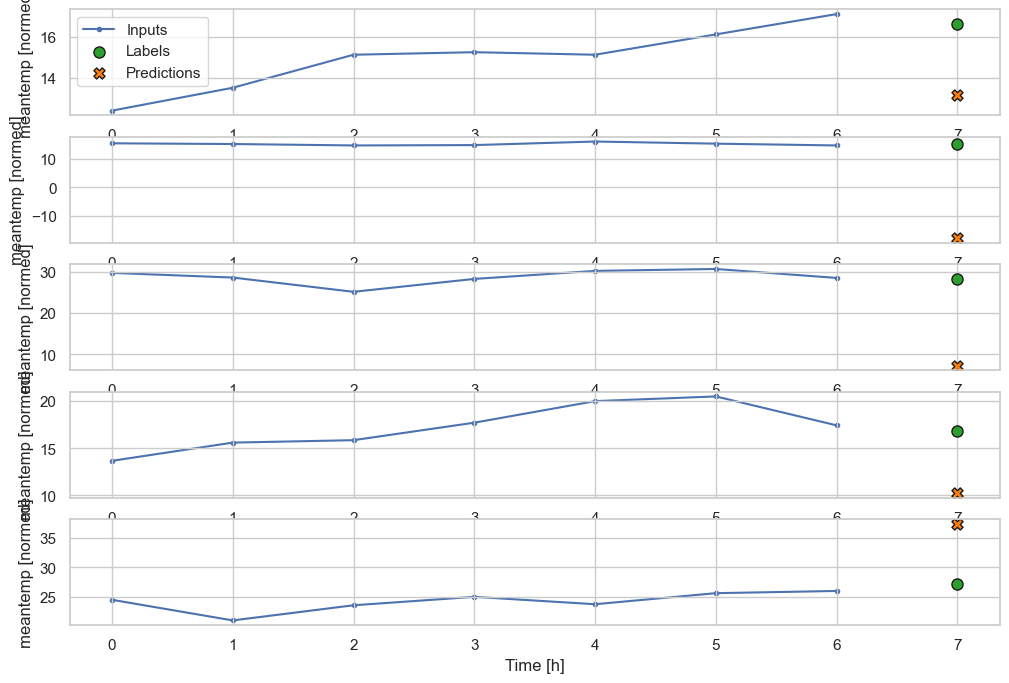

In [88]:
# EJERCICIO: construir un modelo llamado 'lineal' con una única capa densa de una sola unidad. Usar los siguientes 
# elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense

lineal = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

# EJERCICIO: compilar y evaluar el modelo 'lineal' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(lineal, wg_7_1)

resultado_train = lineal.evaluate(wg_7_1.train)[-1]
resultado_val = lineal.evaluate(wg_7_1.val)[-1]
resultado_test = lineal.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['lineal'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('meantemp', model=lineal, max_subplots=5)

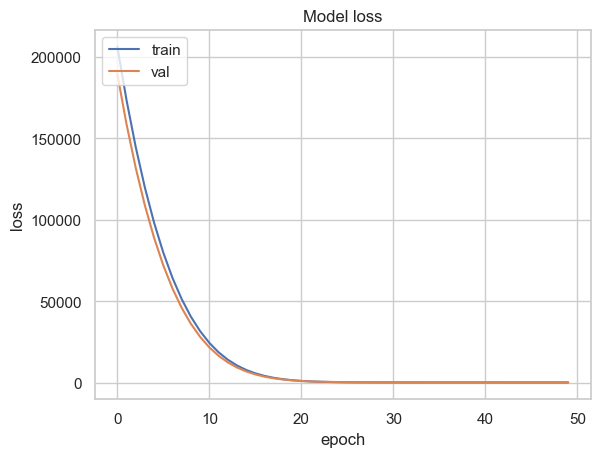

In [91]:
# Ejercicio: Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
# history.history.keys()

# See phone
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [89]:
RESULTADOS

,train,validation,test
lineal,15.188182,15.840293,16.69784


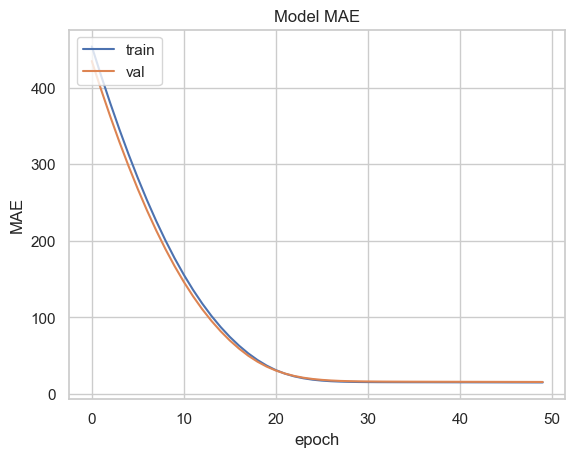

In [92]:
plt.plot(history.history["mean_absolute_error"])
plt.plot(history.history["val_mean_absolute_error"])
plt.title("Model MAE")
plt.ylabel("MAE")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

### 6.3. Modelo denso

In [ ]:
# EJERCICIO: construir un modelo llamado 'denso' con:
#   - Dos capas densas de 4 unidades, con función de activación ReLU
#   - Una capa densa final de una sola unidad, con función de activación lineal
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense

# EJERCICIO: compilar y evaluar el modelo 'denso' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

# the # of layers and # of neurons at each layer is something you should experiment with
denso = tf.keras.Sequential([
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear'),
])

# ... see phone
# history = compile

In [ ]:
# Ejercicio: Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history


### 6.4. Modelo LSTM

In [ ]:
# EJERCICIO: construir y evaluar un modelo llamado 'lstm' con:
#   - Dos capas LSTM con 4 unidades
#   - Una capa densa de una sola unidad
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
#   - tf.keras.layers.LSTM

# EJERCICIO: compilar y evaluar el modelo 'lstm' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

lstm = tf.keras.model.Sequential([
    tf.keras.layers.LSTM
])


In [ ]:
# Ejercicio: Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history


In [ ]:
# EJERCICIO: construir y evaluar un modelo llamado 'lstm_dropout' con:
#   - Dos capas LSTM con 4 unidades
#   - Una capa dropout con una reducción del 20%
#   - Una capa densa de una sola unidad
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
#   - tf.keras.layers.LSTM

# EJERCICIO: compilar y evaluar el modelo 'lstm_dropout' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

# see phone

In [ ]:
# Ejercicio: Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history

# see phone - 4 sec video.

## 7. Predicción múltiple <a name="varios_pasos"> </a>

En esta sección experimentaremos con distintos modelos, para realizar predicciones a partir de una ventana pasada de 7 unidades de tiempo, y una predicción múltiple a futuro también con una ventana de 7 unidades de tiempo. En concreto probaremos:
- Baseline simple
- Distintos modelos de predicción en un paso (modelo de disparo único)
- Un modelo RNN para predicción en varios pasos (modelo auto-regresivo)

Evaluaremos cada experimento con los datos de entrenamiento y validación, y también mostraremos la evolución gráfica de las predicciones de algunos fragmentos del conjunto de datos.

Empezaremos por definir las particiones de entrenamiento, validación y test:

In [ ]:
# Partición del dataset 'weather-delhi' en train-validation-test
datos = DATOS['weather-delhi']

# Proporciones: 70%-20%-10%
tamaño = len(datos)
train = datos[0:int(tamaño*0.7)]
val = datos[int(tamaño*0.7):int(tamaño*0.9)]
test = datos[int(tamaño*0.9):]

### 7.1. Generador de ventanas

Usaremos un generador de ventanas simple

In [ ]:
# EJERCICIO: crear un generador de ventanas wg_7_7 con los siguientes valores
#  - 'train' es el DataFrame de la partición train
#  - 'val' es el DataFrame de la partición validation
#  - 'test' es el DataFrame de la partición test
#  - La anchura de la ventana de entrada es 7
#  - La anchura de la ventana de salida es 7
#  - El retardo es también 7
#  - La única columna de salida es 'meantemp'



### 7.2. Predicción en un paso (disparo único)

Los modelos de salida múltiple en un _disparo único_, realizan la predicción de la secuencia completa en un solo paso. Para ello, bastará con especificar en la capa de salida tantas neuronas como valores a predecir.

Realizaremos los experimentos con los modelos anteriores:
- Lineal
- Denso
- LSTM 

In [ ]:
# EJERCICIO: construir y evaluar un modelo llamado 'multi_lineal' equivalente al modelo lineal
# anterior, pero que produzca 7 predicciones en la salida

# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal-multiple'



In [ ]:
# Ejercicio: Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history


In [ ]:
# EJERCICIO: construir y evaluar un modelo llamado 'multi_denso' con:
#   - Dos capas densas de 4 unidades cada una, con función de activación ReLU
#   - Una capa 'de salida con 7 unidades, y función de activación lineal

# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal-multiple'


In [ ]:
# Ejercicio: Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history


In [ ]:
# EJERCICIO: construir y evaluar un modelo llamado 'multi_lstm' con:
#   - Dos capas LSTM de 4 unidades 
#   - Una capa densa de 7 unidades para producir la salida

# Guardar los resultados en el DataFrame RESULTADOS con la clave 'LSTM-multiple'



In [ ]:
# Ejercicio: Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
